HACKATON; CENICAFE 

CAFETERITOS 

🧪 Análisis de Datos Eddy Covariance para Modelado de NEE

Objetivo: Entrenar un modelo de machine learning para estimar el Intercambio Neto de CO₂ (NEE) en base a variables meteorológicas y de teledetección, usando datos de torre Eddy Covariance.


In [11]:
# ====================================
# MODELO DE MACHINE LEARNING PARA NEE
# ====================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Instalar paquetes necesarios
%pip install pandas matplotlib seaborn scikit-learn xgboost scipy statsmodels geemap



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


1. 📂 Carga y limpieza de datos

Se cargan los datos desde un archivo .csv separado por tabulaciones (\t). Los valores faltantes vienen codificados como -9999, por lo que se reemplazan por NaN para su correcto tratamiento.

También se convierte la columna TIMESTAMP_START al formato de fecha y hora estándar (datetime) para facilitar el filtrado temporal.

In [2]:
# ---------------------------
# 1. Cargar los datos
# ---------------------------
archivo = "AMF_CR-Fsc_BASE_HH_2-5.csv"  # ← CAMBIA este nombre por el archivo real

# Leer el archivo CSV eliminando las primeras 2 filas de metadatos
df = pd.read_csv(archivo, sep=",", skiprows=2, low_memory=False)

print(f"✅ Archivo leído exitosamente")

print(f"📊 Filas: {len(df)}")
print(f"📋 Columnas: {len(df.columns)}")
print(f"📋 Primeras 5 columnas: {list(df.columns[:5])}")
print(f"\n📋 Primeras 3 filas:")
print(df.head(3))

✅ Archivo leído exitosamente
📊 Filas: 70115
📋 Columnas: 57
📋 Primeras 5 columnas: ['TIMESTAMP_START', 'TIMESTAMP_END', 'CO2', 'CO2_MIXING_RATIO', 'FC']

📋 Primeras 3 filas:
   TIMESTAMP_START  TIMESTAMP_END         CO2  CO2_MIXING_RATIO        FC  \
0     201501010000   201501010030  276.761726        276.761726  2.386020   
1     201501010030   201501010100  280.025144        280.025144  4.211771   
2     201501010100   201501010130  280.535864        280.535864  4.721451   

      H2O  H2O_MIXING_RATIO        SC       G          H  ...        ZL  \
0 -9999.0           -9999.0 -0.049194 -9999.0 -36.600471  ...  0.048297   
1 -9999.0           -9999.0  0.460073 -9999.0 -46.133074  ...  0.036169   
2 -9999.0           -9999.0  0.071981 -9999.0 -56.596398  ...  0.036736   

   GPP_PI_F  NEE_PI_F    RECO_PI_F    LE_PI_F   H_PI_F  FC_SSITC_TEST  \
0   -9999.0  4.485861 -9999.000000  18.355475 -43.4925              0   
1       0.0  4.671844     0.911083  24.876455 -46.1330              1  

2. ⏳ Filtro temporal: desde 9 de diciembre de 2016 a las 10:30

Los datos de teledetección (NDVI, PRI) solo están disponibles desde finales de 2016. Por tanto, se filtran los registros para trabajar solo con los datos a partir del 9 de diciembre de 2016 a las 10:30 am.

3. 🕒 Extracción de variables temporales

Se derivan columnas auxiliares a partir del timestamp para capturar la estacionalidad (doy: día del año) y el ciclo diurno (hour: hora decimal).

In [3]:
# ---------------------------
# 2. Limpieza inicial
# ---------------------------
df.replace(-9999, np.nan, inplace=True)
df['TIMESTAMP_START'] = pd.to_datetime(df['TIMESTAMP_START'], format="%Y%m%d%H%M")

# ---------------------------
# 3. Filtro desde NDVI no NaN
# ---------------------------
# Filtrar registros donde NDVI no sea NaN
df = df[df['NDVI'].notna()].reset_index(drop=True)

print("Tamaño de la base tras filtro NDVI no NaN:", len(df))
print("Periodo de la base de datos después del filtro NDVI no NaN:")
print("Inicio:", df['TIMESTAMP_START'].min())
print("Fin   :", df['TIMESTAMP_START'].max())

# Analizar huecos temporales en la serie cada 30 minutos
df_sorted = df.sort_values('TIMESTAMP_START').reset_index(drop=True)
intervalo_esperado = pd.Timedelta(minutes=30)
diferencias = df_sorted['TIMESTAMP_START'].diff()
huecos = df_sorted[diferencias > intervalo_esperado]

print(f"Total de huecos encontrados: {len(huecos)}")
if not huecos.empty:
    print("Primeros 5 huecos:")
    for idx in huecos.index[:5]:
        anterior = df_sorted.loc[idx - 1, 'TIMESTAMP_START']
        actual = df_sorted.loc[idx, 'TIMESTAMP_START']
        print(f"Hueco entre {anterior} y {actual} (diferencia: {actual - anterior})")
else:
    print("No se encontraron huecos temporales mayores a 30 minutos.")

Tamaño de la base tras filtro NDVI no NaN: 13716
Periodo de la base de datos después del filtro NDVI no NaN:
Inicio: 2016-12-09 10:30:00
Fin   : 2018-12-31 17:00:00
Total de huecos encontrados: 614
Primeros 5 huecos:
Hueco entre 2016-12-09 16:30:00 y 2016-12-10 06:00:00 (diferencia: 0 days 13:30:00)
Hueco entre 2016-12-10 17:00:00 y 2016-12-11 06:00:00 (diferencia: 0 days 13:00:00)
Hueco entre 2016-12-11 16:30:00 y 2016-12-12 06:00:00 (diferencia: 0 days 13:30:00)
Hueco entre 2016-12-12 16:30:00 y 2016-12-13 06:00:00 (diferencia: 0 days 13:30:00)
Hueco entre 2016-12-13 16:30:00 y 2016-12-14 06:00:00 (diferencia: 0 days 13:30:00)


4. 🔢 Selección de variables predictoras y objetivo

A continuación se listan las variables seleccionadas como entradas del modelo y su variable objetivo. Se incluye su unidad y una breve descripción: 

| Variable       | Unidad              | Descripción                                                                 |
|----------------|----------------------|-----------------------------------------------------------------------------|
| `TA_1_1_1`     | °C                   | Temperatura del aire (sensor a 1.1 m)                                       |
| `RH_1_1_1`     | %                    | Humedad relativa (sensor a 1.1 m)                                           |
| `VPD_PI`       | hPa                  | Déficit de presión de vapor                                                |
| `SW_IN_1_1_1`  | W m⁻²                | Radiación solar de onda corta entrante                                     |
| `LW_IN`        | W m⁻²                | Radiación de onda larga entrante                                           |
| `P`            | mm                   | Precipitación acumulada                                                    |
| `WS`           | m s⁻¹                | Velocidad del viento                                                       |
| `NDVI`         | adimensional (0–1)   | Índice de vegetación normalizado (NDVI)                                    |
| `PRI`          | adimensional         | Índice de reflectancia fotosintética (Photochemical Reflectance Index)     |
| `doy`          | Día del año (1–366)  | Día del año para capturar estacionalidad                                   |
| `hour`         | Hora decimal (0–24)  | Hora decimal del día para capturar el ciclo diurno                         |
| `NEE_PI_F`     | toneladas CO₂/ha     | **Intercambio Neto de Carbono (variable objetivo a predecir)**             |

In [ ]:
# ---------------------------
# 4. Variables temporales útiles
# ---------------------------
df['year'] = df['TIMESTAMP_START'].dt.year
df['month'] = df['TIMESTAMP_START'].dt.month
df['doy'] = df['TIMESTAMP_START'].dt.dayofyear
df['hour'] = df['TIMESTAMP_START'].dt.hour + df['TIMESTAMP_START'].dt.minute / 60

5. 📊 Análisis exploratorio de variables

Se presentan dos tipos de análisis:
	•	Estadísticas descriptivas de las variables predictoras (media, desviación, mínimo, máximo, etc.).
	•	Correlación entre todas las variables, enfocándose en la relación entre las entradas y el NEE (NEE_PI_F), usando un mapa de calor (heatmap).

Este análisis permite identificar relaciones clave, redundancias y la importancia potencial de cada variable.

In [5]:
# ---------------------------
# 5. Variables seleccionadas
# ---------------------------
variables_entrada = [
    'TA_1_1_1', 'RH_1_1_1', 'VPD_PI',
    'SW_IN_1_1_1', 'LW_IN', 'P', 'WS',
    'NDVI', 'PRI', 'doy', 'hour'
]
variable_objetivo = 'NEE_PI_F'

📊 RESUMEN GENERAL DEL DATASET
Total de registros válidos: 7,039
Período de datos: 2016-12-14 09:00:00 - 2018-07-06 17:00:00
Años disponibles: [2016, 2017, 2018]
Registros por año: {2016: 128, 2017: 3996, 2018: 2915}


C:\Users\joser\AppData\Local\Temp\ipykernel_25796\1854969704.py:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\joser\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


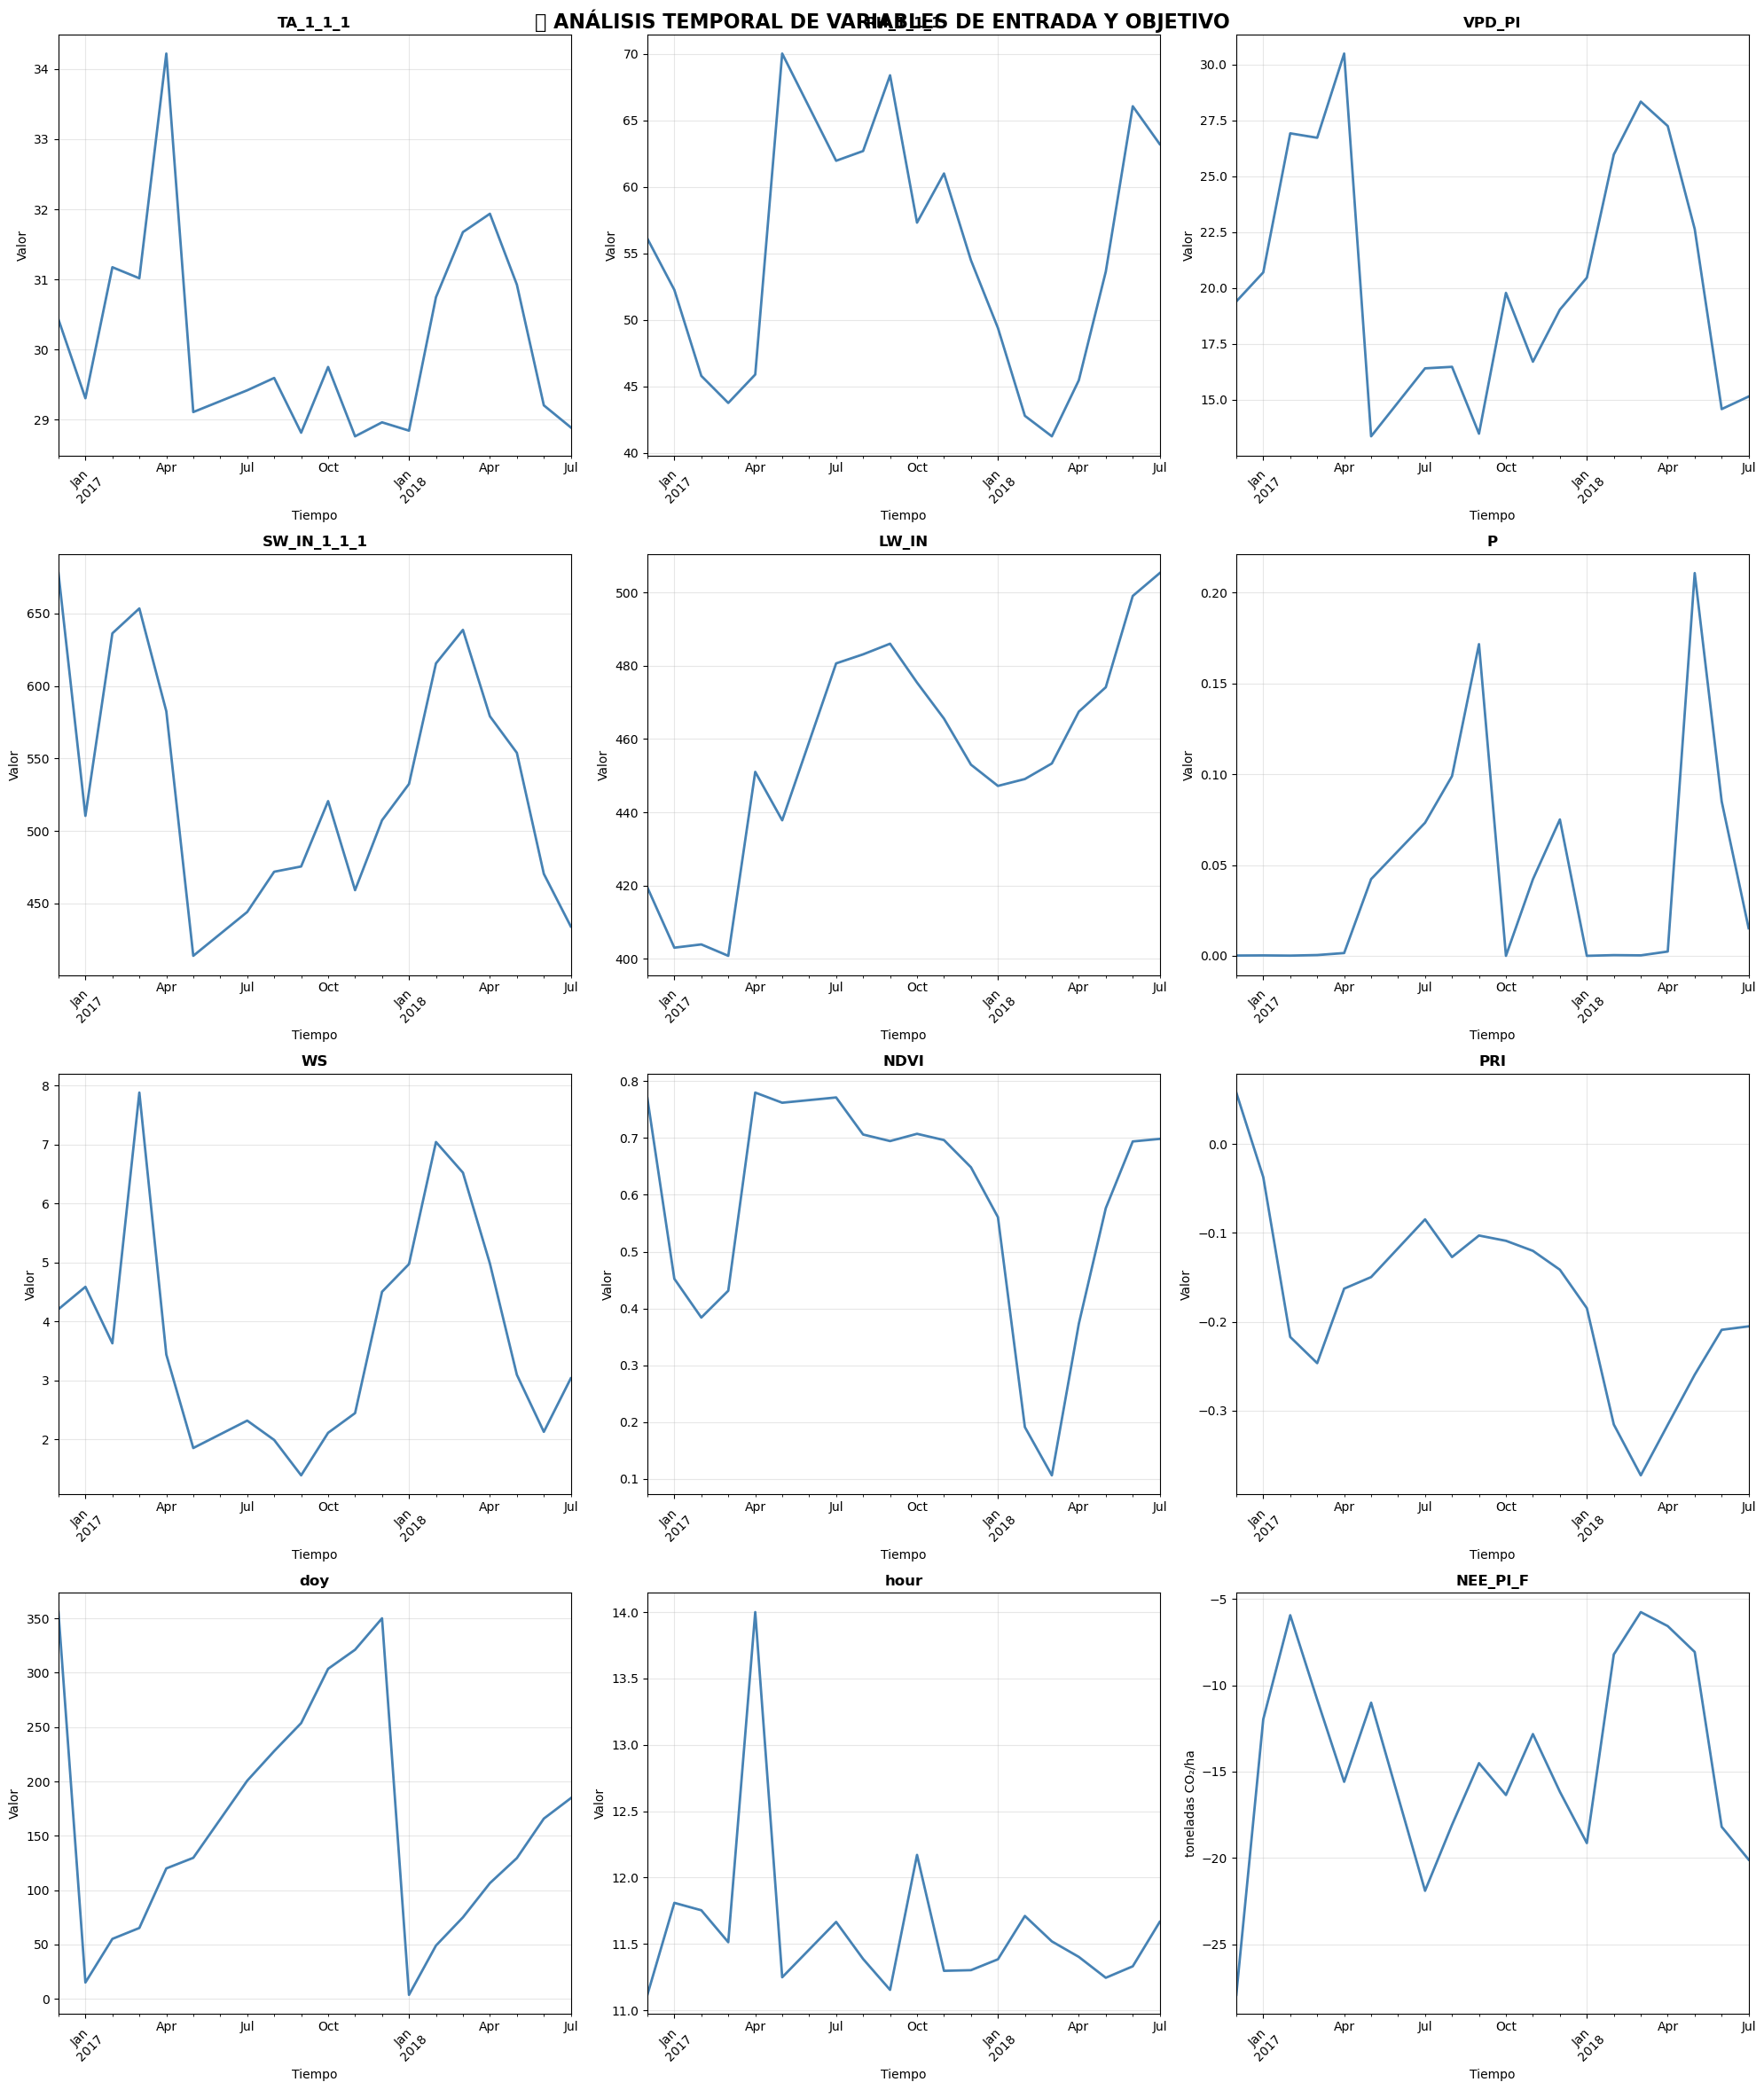


📊 ESTADÍSTICAS DESCRIPTIVAS DETALLADAS
       TA_1_1_1  RH_1_1_1    VPD_PI  SW_IN_1_1_1     LW_IN         P  \
count  7039.000  7039.000  7039.000     7039.000  7039.000  7039.000   
mean     30.003    55.214    20.344      526.562   459.956     0.056   
std       2.980    15.198     9.255      311.597    33.707     0.721   
min      19.661    25.377     1.991        8.510   355.621     0.000   
25%      28.042    43.794    13.786      244.297   440.259     0.000   
50%      30.436    53.012    20.601      532.282   461.867     0.000   
75%      32.148    64.298    26.799      804.456   481.026     0.000   
max      36.723    91.770    45.009     1159.447   567.588    24.120   

             WS      NDVI       PRI       doy      hour  NEE_PI_F  
count  7039.000  7039.000  7039.000  7039.000  7039.000  7039.000  
mean      3.856     0.545    -0.193   170.871    11.436   -13.098  
std       2.621     0.267     0.116   105.824     3.241    12.966  
min       0.060    -0.281    -0.605    

In [6]:
# ========================================
# ANÁLISIS PROFUNDO DE VARIABLES
# ========================================

# Filtrar datos válidos para el análisis
df_analisis = df.dropna(subset=variables_entrada + [variable_objetivo])

print(f"📊 RESUMEN GENERAL DEL DATASET")
print(f"{'='*50}")
print(f"Total de registros válidos: {len(df_analisis):,}")
print(f"Período de datos: {df_analisis['TIMESTAMP_START'].min()} - {df_analisis['TIMESTAMP_START'].max()}")
print(f"Años disponibles: {sorted(df_analisis['year'].unique())}")
print(f"Registros por año: {df_analisis['year'].value_counts().sort_index().to_dict()}")

# Crear figura con subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 24))
fig.suptitle('📈 ANÁLISIS TEMPORAL DE VARIABLES DE ENTRADA Y OBJETIVO', fontsize=16, fontweight='bold')

# Análisis de cada variable
for i, var in enumerate(variables_entrada + [variable_objetivo]):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Serie temporal mensual
    monthly_data = df_analisis.groupby(df_analisis['TIMESTAMP_START'].dt.to_period('M'))[var].mean()
    monthly_data.plot(ax=ax, linewidth=2, color='steelblue')
    
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Tiempo')
    if var == variable_objetivo:
        ax.set_ylabel('toneladas CO₂/ha')
    else:
        ax.set_ylabel('Valor')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Análisis estadístico detallado
print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS DETALLADAS")
print(f"{'='*60}")
stats = df_analisis[variables_entrada + [variable_objetivo]].describe()
print(stats.round(3))

# Análisis de valores faltantes
print(f"\n🔍 ANÁLISIS DE VALORES FALTANTES")
print(f"{'='*40}")
missing_data = df[variables_entrada + [variable_objetivo]].isnull().sum()
missing_pct = (missing_data / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Variable': missing_data.index,
    'Valores_Faltantes': missing_data.values,
    'Porcentaje': missing_pct.values
}).sort_values('Porcentaje', ascending=False)
print(missing_df.to_string(index=False))

C:\Users\joser\AppData\Local\Temp\ipykernel_25796\2473355864.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis['season'] = df_analisis['month'].map({
C:\Users\joser\AppData\Local\Temp\ipykernel_25796\2473355864.py:63: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
C:\Users\joser\AppData\Local\Temp\ipykernel_25796\2473355864.py:63: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  plt.tight_layout()
C:\Users\joser\AppData\Local\Temp\ipykernel_25796\2473355864.py:63: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
C:\Users\joser\AppData\Local\Temp\ipykernel_25796\2473355864.py:63: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing

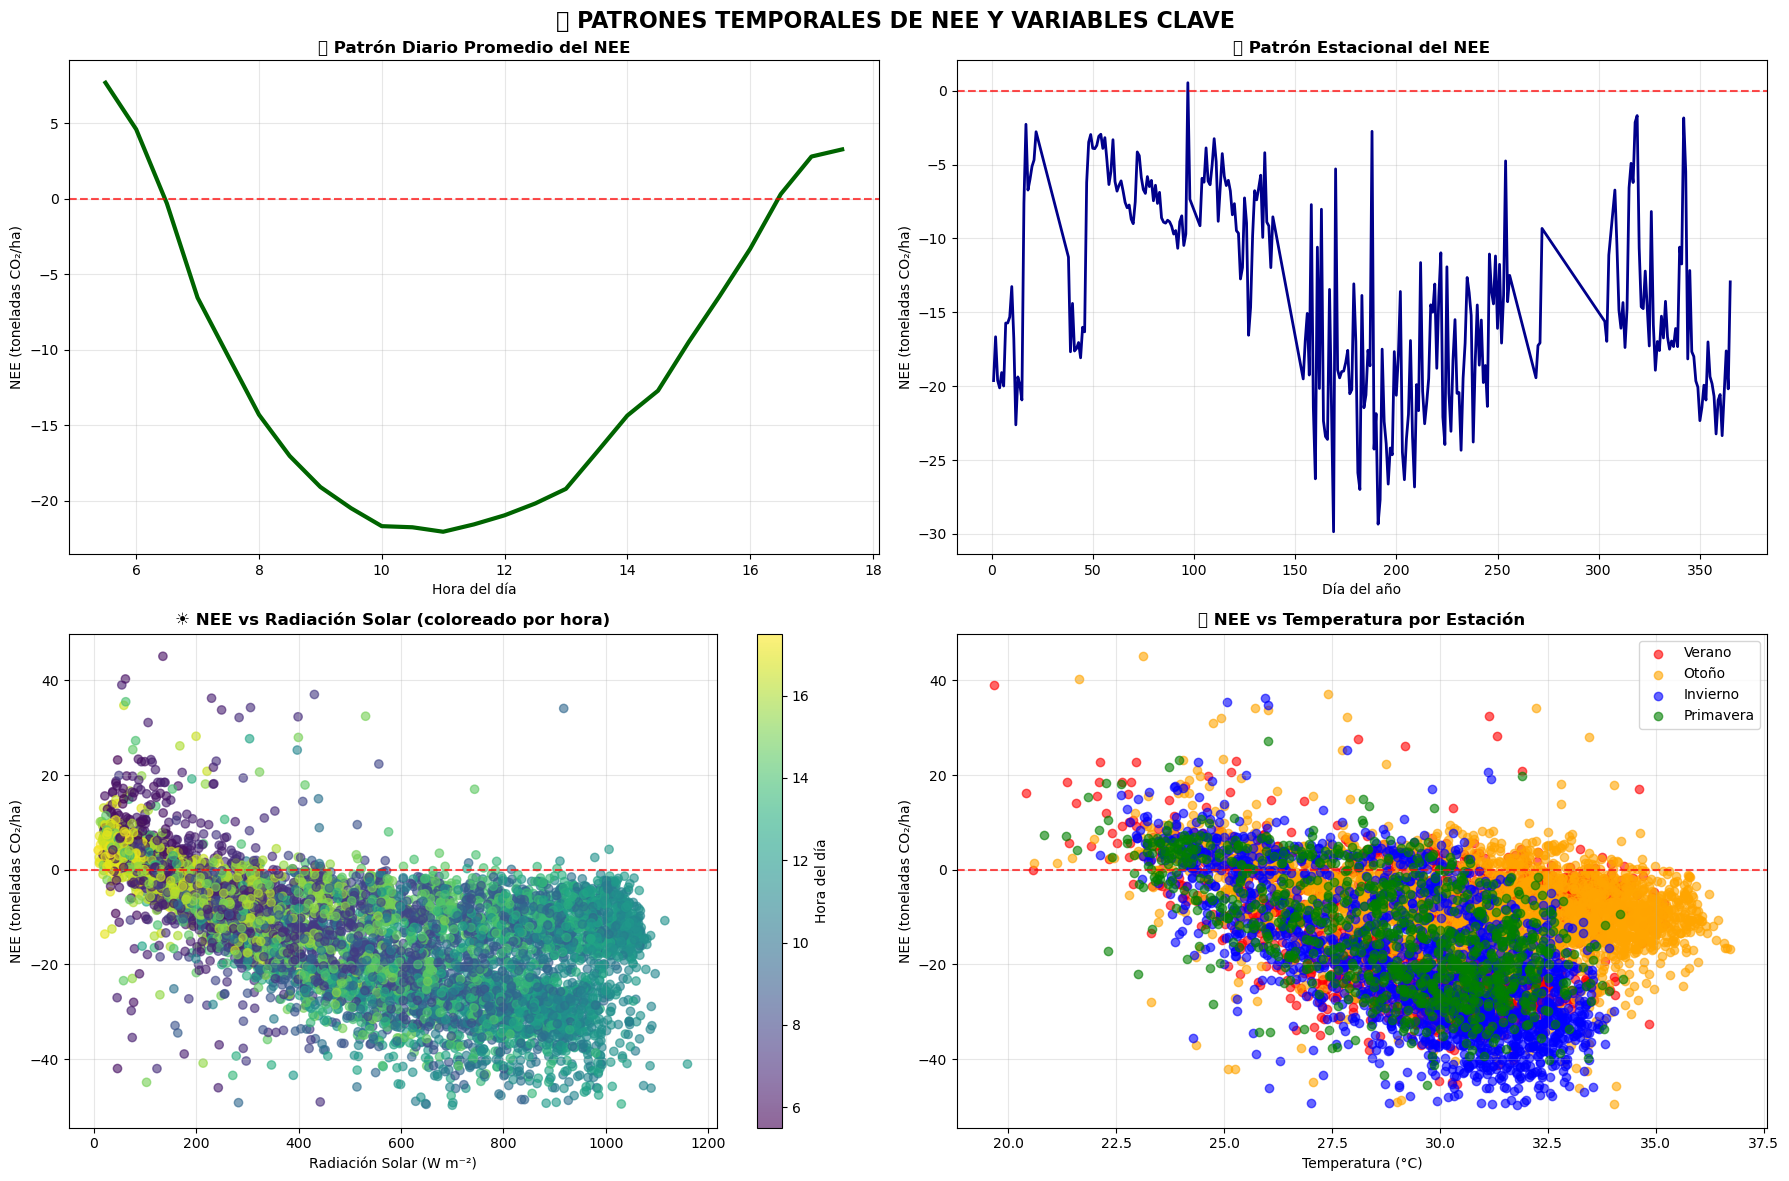


🔍 ANÁLISIS DE CORRELACIONES POR PERÍODO DEL DÍA

📊 Mañana (3770 registros):
Top 3 variables más correlacionadas con NEE:
  1. NDVI: -0.620
  2. hour: -0.479
  3. SW_IN_1_1_1: -0.455

📊 Tarde (3002 registros):
Top 3 variables más correlacionadas con NEE:
  1. SW_IN_1_1_1: -0.622
  2. hour: 0.613
  3. LW_IN: -0.355

📊 Madrugada (267 registros):
Top 3 variables más correlacionadas con NEE:
  1. TA_1_1_1: -0.224
  2. SW_IN_1_1_1: -0.111
  3. hour: -0.110

🌍 ANÁLISIS DE CORRELACIONES POR ESTACIÓN

🌱 Verano (1892 registros):
Top 3 variables más correlacionadas con NEE:
  1. NDVI: -0.642
  2. SW_IN_1_1_1: -0.596
  3. PRI: -0.359

🌱 Otoño (2397 registros):
Top 3 variables más correlacionadas con NEE:
  1. SW_IN_1_1_1: -0.616
  2. TA_1_1_1: -0.361
  3. NDVI: -0.358

🌱 Invierno (1807 registros):
Top 3 variables más correlacionadas con NEE:
  1. SW_IN_1_1_1: -0.838
  2. TA_1_1_1: -0.647
  3. RH_1_1_1: 0.607

🌱 Primavera (943 registros):
Top 3 variables más correlacionadas con NEE:
  1. SW_IN_1_1

C:\Users\joser\AppData\Local\Temp\ipykernel_25796\2473355864.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis['periodo_dia'] = pd.cut(df_analisis['hour'],


In [7]:
# ========================================
# ANÁLISIS DE PATRONES TEMPORALES
# ========================================

# Crear figura para análisis de patrones temporales
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('⏰ PATRONES TEMPORALES DE NEE Y VARIABLES CLAVE', fontsize=16, fontweight='bold')

# 1. Patrón diario promedio del NEE
ax1 = axes[0, 0]
daily_pattern = df_analisis.groupby('hour')[variable_objetivo].mean()
daily_pattern.plot(kind='line', ax=ax1, color='darkgreen', linewidth=3)
ax1.set_title('📅 Patrón Diario Promedio del NEE', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hora del día')
ax1.set_ylabel('NEE (toneladas CO₂/ha)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# 2. Patrón estacional del NEE
ax2 = axes[0, 1]
seasonal_pattern = df_analisis.groupby('doy')[variable_objetivo].mean()
seasonal_pattern.plot(kind='line', ax=ax2, color='darkblue', linewidth=2)
ax2.set_title('🌱 Patrón Estacional del NEE', fontsize=12, fontweight='bold')
ax2.set_xlabel('Día del año')
ax2.set_ylabel('NEE (toneladas CO₂/ha)')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# 3. Relación NEE vs Radiación Solar por hora
ax3 = axes[1, 0]
scatter = ax3.scatter(df_analisis['SW_IN_1_1_1'], df_analisis[variable_objetivo], 
                     c=df_analisis['hour'], cmap='viridis', alpha=0.6)
ax3.set_title('☀️ NEE vs Radiación Solar (coloreado por hora)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Radiación Solar (W m⁻²)')
ax3.set_ylabel('NEE (toneladas CO₂/ha)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.colorbar(scatter, ax=ax3, label='Hora del día')

# 4. Relación NEE vs Temperatura por estación
ax4 = axes[1, 1]
# Definir estaciones
df_analisis['season'] = df_analisis['month'].map({
    12: 'Verano', 1: 'Verano', 2: 'Verano',
    3: 'Otoño', 4: 'Otoño', 5: 'Otoño',
    6: 'Invierno', 7: 'Invierno', 8: 'Invierno',
    9: 'Primavera', 10: 'Primavera', 11: 'Primavera'
})

colors = {'Verano': 'red', 'Otoño': 'orange', 'Invierno': 'blue', 'Primavera': 'green'}
for season in df_analisis['season'].unique():
    season_data = df_analisis[df_analisis['season'] == season]
    ax4.scatter(season_data['TA_1_1_1'], season_data[variable_objetivo], 
               c=colors[season], alpha=0.6, label=season)

ax4.set_title('🌡️ NEE vs Temperatura por Estación', fontsize=12, fontweight='bold')
ax4.set_xlabel('Temperatura (°C)')
ax4.set_ylabel('NEE (toneladas CO₂/ha)')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Análisis de correlaciones por período del día
print(f"\n🔍 ANÁLISIS DE CORRELACIONES POR PERÍODO DEL DÍA")
print(f"{'='*60}")

# Definir períodos del día
df_analisis['periodo_dia'] = pd.cut(df_analisis['hour'], 
                                   bins=[0, 6, 12, 18, 24], 
                                   labels=['Madrugada', 'Mañana', 'Tarde', 'Noche'])

for periodo in df_analisis['periodo_dia'].unique():
    if pd.notna(periodo):
        periodo_data = df_analisis[df_analisis['periodo_dia'] == periodo]
        correlaciones_periodo = periodo_data[variables_entrada + [variable_objetivo]].corr()
        nee_corr = correlaciones_periodo[variable_objetivo].drop(variable_objetivo).sort_values(key=abs, ascending=False)
        
        print(f"\n📊 {periodo} ({len(periodo_data)} registros):")
        print(f"Top 3 variables más correlacionadas con NEE:")
        for i, (var, corr) in enumerate(nee_corr.head(3).items()):
            print(f"  {i+1}. {var}: {corr:.3f}")

# Análisis estacional
print(f"\n🌍 ANÁLISIS DE CORRELACIONES POR ESTACIÓN")
print(f"{'='*50}")

for season in df_analisis['season'].unique():
    season_data = df_analisis[df_analisis['season'] == season]
    correlaciones_season = season_data[variables_entrada + [variable_objetivo]].corr()
    nee_corr = correlaciones_season[variable_objetivo].drop(variable_objetivo).sort_values(key=abs, ascending=False)
    
    print(f"\n🌱 {season} ({len(season_data)} registros):")
    print(f"Top 3 variables más correlacionadas con NEE:")
    for i, (var, corr) in enumerate(nee_corr.head(3).items()):
        print(f"  {i+1}. {var}: {corr:.3f}")

C:\Users\joser\AppData\Local\Temp\ipykernel_25796\905780837.py:72: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\joser\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


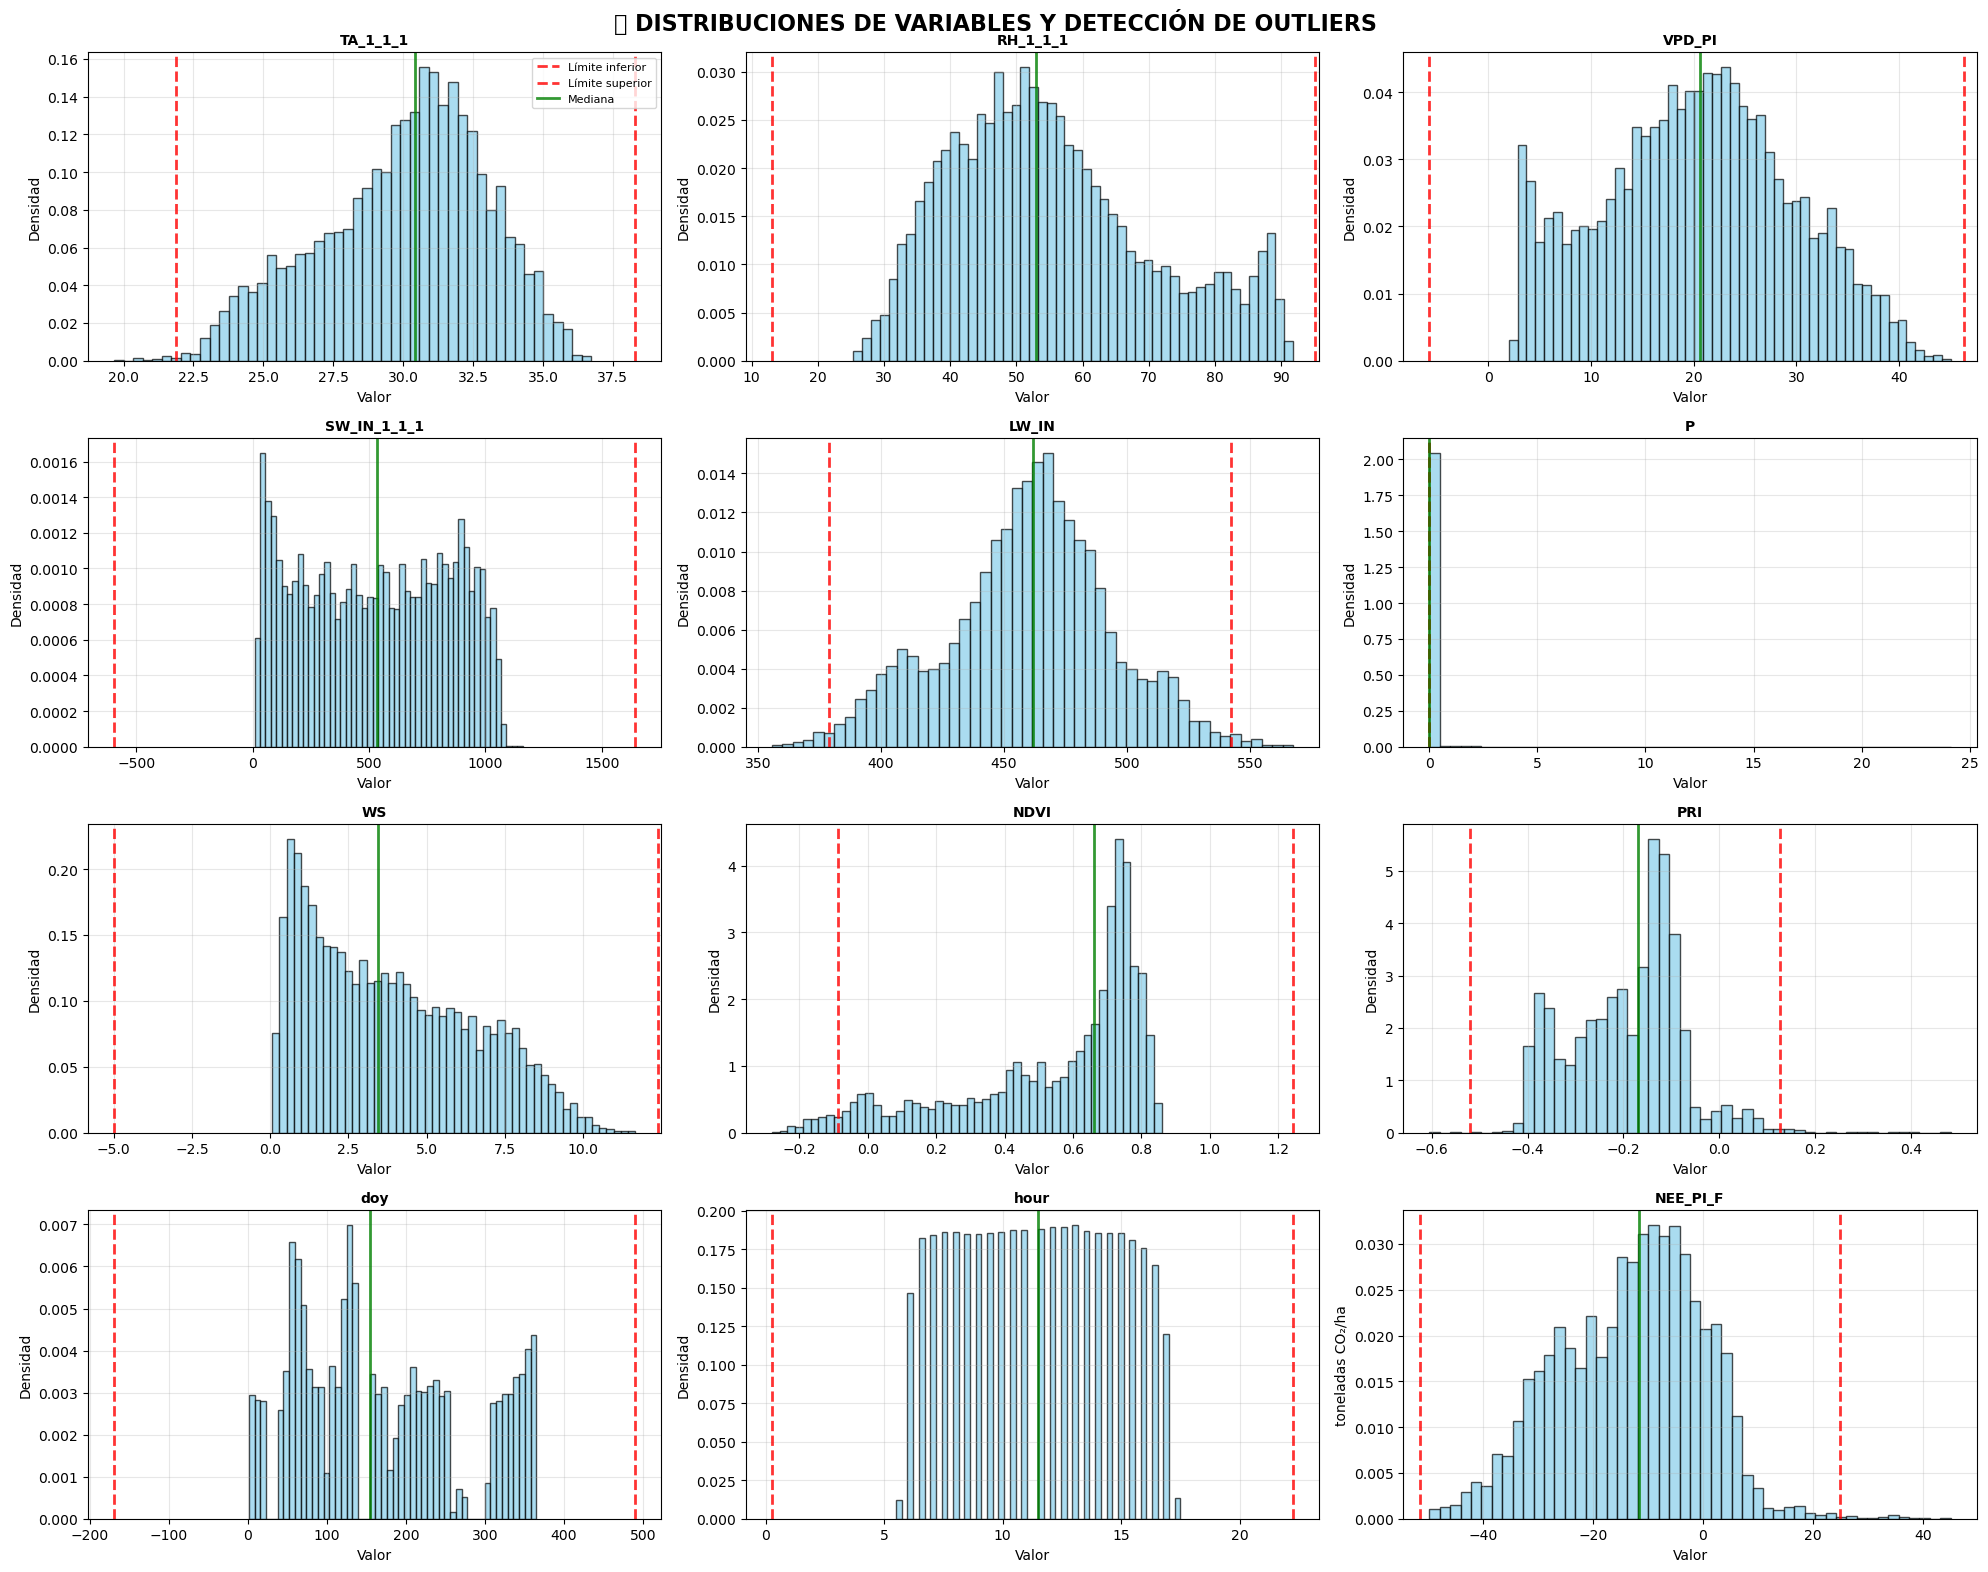


🚨 RESUMEN DE OUTLIERS Y ESTADÍSTICAS
   Variable  Total_Outliers  Porcentaje_Outliers  Limite_Inferior  Limite_Superior     Min      Max   Media  Mediana  Desviacion_Std
   TA_1_1_1              14                 0.20           21.883           38.307  19.661   36.723  30.003   30.436           2.980
   RH_1_1_1               0                 0.00           13.038           95.055  25.377   91.770  55.214   53.012          15.198
     VPD_PI               0                 0.00           -5.734           46.318   1.991   45.009  20.344   20.601           9.255
SW_IN_1_1_1               0                 0.00         -595.941         1644.693   8.511 1159.447 526.562  532.283         311.597
      LW_IN             107                 1.52          379.109          542.176 355.621  567.587 459.956  461.867          33.707
          P             355                 5.04            0.000            0.000   0.000   24.120   0.056    0.000           0.721
         WS               0    

C:\Users\joser\AppData\Local\Temp\ipykernel_25796\905780837.py:122: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
C:\Users\joser\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


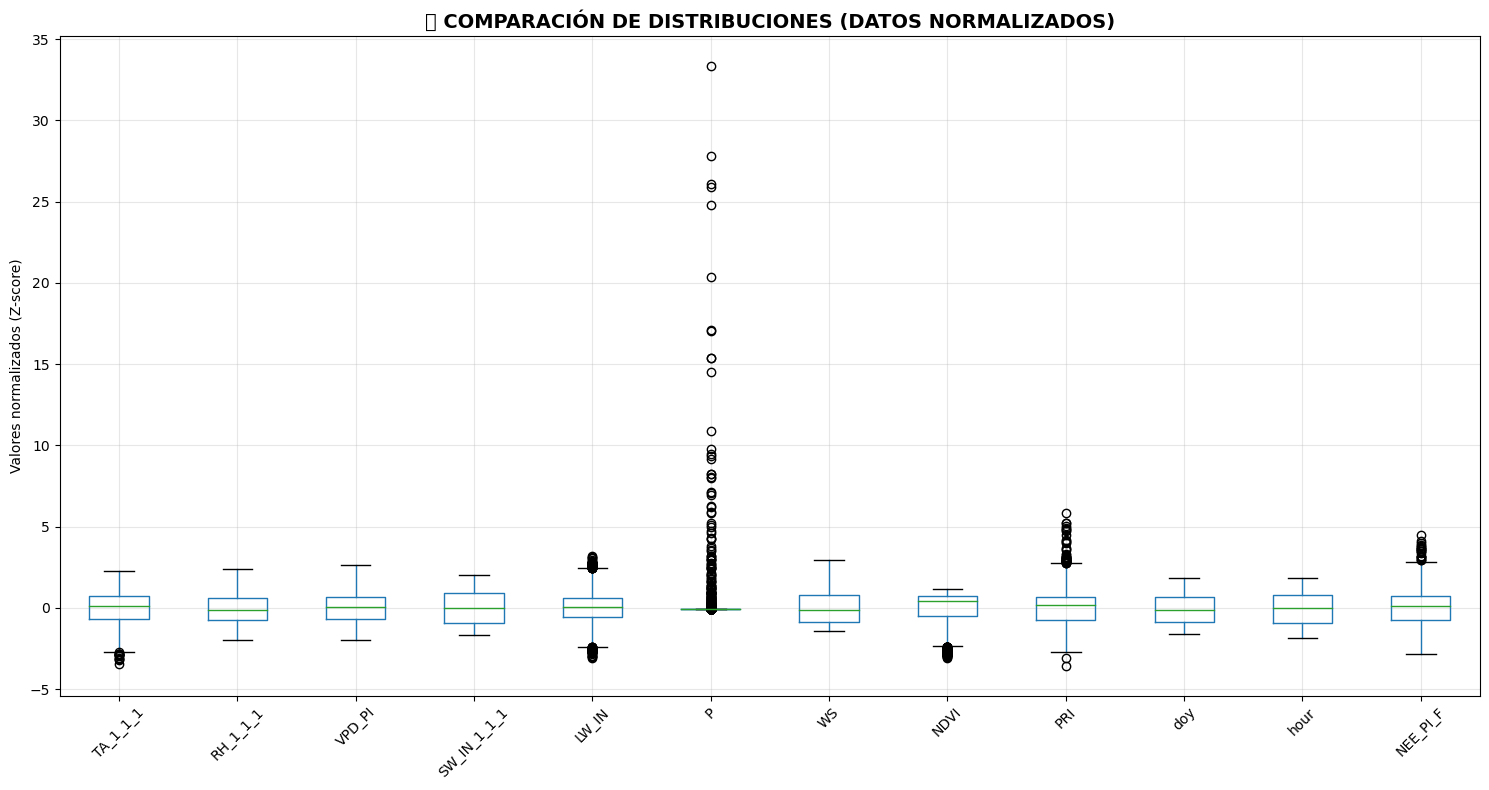

In [8]:
# ========================================
# ANÁLISIS DE DISTRIBUCIONES Y OUTLIERS
# ========================================

# Crear figura para análisis de distribuciones
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
fig.suptitle('📊 DISTRIBUCIONES DE VARIABLES Y DETECCIÓN DE OUTLIERS', fontsize=16, fontweight='bold')

# Análisis de distribuciones y outliers
outlier_summary = []

for i, var in enumerate(variables_entrada + [variable_objetivo]):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Obtener datos de la variable
    data = df_analisis[var].dropna()
    
    # Crear histograma
    ax.hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    ax.set_title(f'{var}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Valor')
    if var == variable_objetivo:
        ax.set_ylabel('toneladas CO₂/ha')
    else:
        ax.set_ylabel('Densidad')
    ax.grid(True, alpha=0.3)
    
    # Calcular estadísticas de outliers usando IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct = (len(outliers) / len(data)) * 100
    
    # Agregar líneas verticales para límites de outliers
    ax.axvline(lower_bound, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Límite inferior')
    ax.axvline(upper_bound, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Límite superior')
    
    # Agregar línea para la mediana
    ax.axvline(data.median(), color='green', linestyle='-', alpha=0.8, linewidth=2, label='Mediana')
    
    # Agregar leyenda solo en el primer subplot
    if i == 0:
        ax.legend(fontsize=8)
    
    # Guardar información de outliers
    outlier_summary.append({
        'Variable': var,
        'Total_Outliers': len(outliers),
        'Porcentaje_Outliers': round(outlier_pct, 2),
        'Limite_Inferior': round(lower_bound, 3),
        'Limite_Superior': round(upper_bound, 3),
        'Min': round(data.min(), 3),
        'Max': round(data.max(), 3),
        'Media': round(data.mean(), 3),
        'Mediana': round(data.median(), 3),
        'Desviacion_Std': round(data.std(), 3)
    })

# Remover subplots vacíos si los hay
for i in range(len(variables_entrada + [variable_objetivo]), 12):
    row = i // 3
    col = i % 3
    if row < 4 and col < 3:
        axes[row, col].remove()

plt.tight_layout()
plt.show()

# Mostrar resumen de outliers
print(f"\n🚨 RESUMEN DE OUTLIERS Y ESTADÍSTICAS")
print(f"{'='*80}")
outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

# Análisis de valores extremos en NEE
print(f"\n⚠️  ANÁLISIS DE VALORES EXTREMOS EN NEE")
print(f"{'='*40}")
nee_data = df_analisis[variable_objetivo]
print(f"Valores más negativos (mayor absorción de CO₂):")
print(nee_data.nsmallest(5).to_string())
print(f"\nValores más positivos (mayor emisión de CO₂):")
print(nee_data.nlargest(5).to_string())

# Análisis de condiciones extremas
print(f"\n🌡️  CONDICIONES DURANTE VALORES EXTREMOS DE NEE")
print(f"{'='*50}")

# Condiciones durante máxima absorción
max_absorption_idx = nee_data.idxmin()
max_absorption_conditions = df_analisis.loc[max_absorption_idx, variables_entrada + ['TIMESTAMP_START']]
print(f"Condiciones durante máxima absorción (NEE = {nee_data.min():.3f}):")
print(f"Fecha: {max_absorption_conditions['TIMESTAMP_START']}")
for var in variables_entrada:
    print(f"  {var}: {max_absorption_conditions[var]:.3f}")

# Condiciones durante máxima emisión
max_emission_idx = nee_data.idxmax()
max_emission_conditions = df_analisis.loc[max_emission_idx, variables_entrada + ['TIMESTAMP_START']]
print(f"\nCondiciones durante máxima emisión (NEE = {nee_data.max():.3f}):")
print(f"Fecha: {max_emission_conditions['TIMESTAMP_START']}")
for var in variables_entrada:
    print(f"  {var}: {max_emission_conditions[var]:.3f}")

# Crear boxplot para comparar variables
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
data_normalized = df_analisis[variables_entrada + [variable_objetivo]].copy()
# Normalizar para comparar en el mismo gráfico
from sklearn.preprocessing import StandardScaler
scaler_viz = StandardScaler()
data_normalized[variables_entrada + [variable_objetivo]] = scaler_viz.fit_transform(data_normalized[variables_entrada + [variable_objetivo]])

data_normalized.boxplot(ax=ax, rot=45, grid=True)
ax.set_title('📦 COMPARACIÓN DE DISTRIBUCIONES (DATOS NORMALIZADOS)', fontsize=14, fontweight='bold')
ax.set_ylabel('Valores normalizados (Z-score)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

6. ⚙️ Preparación de los datos para entrenamiento

Se dividen los datos en dos subconjuntos:
	•	Entrenamiento: registros desde diciembre de 2016 hasta finales de 2017.
	•	Prueba: registros del año 2018, para evaluar la capacidad de generalización del modelo.

Adicionalmente, se aplica una normalización tipo Z-score (media cero, desviación unitaria) a las variables predictoras.

In [9]:
# ---------------------------
# 6. Filtrar datos válidos y robustecer preprocesamiento
# ---------------------------

def eliminar_outliers_iqr(df, variables):
    df_filtrado = df.copy()
    for var in variables:
        Q1 = df_filtrado[var].quantile(0.25)
        Q3 = df_filtrado[var].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_filtrado = df_filtrado[(df_filtrado[var] >= lower) & (df_filtrado[var] <= upper)]
    return df_filtrado

# 1. Eliminar outliers en variables de entrada y objetivo
df_sin_outliers = eliminar_outliers_iqr(df, variables_entrada + [variable_objetivo])

# 2. Eliminar filas con valores faltantes en variables seleccionadas
df_modelo = df_sin_outliers.dropna(subset=variables_entrada + [variable_objetivo])

# 3. (Ya no se filtra por periodo temporal aquí)

print(f"Registros finales para modelado: {len(df_modelo):,}")
print(f"Ventana temporal: {df_modelo['TIMESTAMP_START'].min()} - {df_modelo['TIMESTAMP_START'].max()}")
print(f"Años incluidos: {sorted(df_modelo['year'].unique())}")

Registros finales para modelado: 6,497
Ventana temporal: 2016-12-14 09:00:00 - 2018-07-06 17:00:00
Años incluidos: [2016, 2017, 2018]


El paso de ~13,000 registros a 6,497 se debe a la combinación de varios filtros estrictos aplicados en el preprocesamiento, especialmente:

1. **Eliminación de outliers**:  
   Se usa la función `eliminar_outliers_iqr` para cada variable de entrada y la variable objetivo. Este método elimina cualquier fila donde alguna de estas variables esté fuera del rango intercuartílico (IQR). Si una fila es outlier en cualquier variable, se elimina. Esto ya puede reducir bastante el tamaño.

2. **Eliminación de filas con NaN en cualquier variable relevante**:  
   Después de quitar outliers, se eliminan todas las filas que tengan al menos un valor faltante (`NaN`) en cualquiera de las variables de entrada o en la variable objetivo.  
   - Si tienes 11 variables de entrada + 1 objetivo = 12 columnas, y los NaN están distribuidos (no siempre en la misma fila), la intersección de filas completas puede ser mucho menor que el total de filas con algún NaN individual.
   - Por ejemplo, si cada columna tiene un 10% de NaN, pero en diferentes filas, el resultado final puede ser mucho menos del 90% de los datos originales.

3. **Filtros previos**:  
   - Se eliminan filas con NDVI NaN al inicio.
   - Se filtra el periodo temporal (desde diciembre 2016).
   - Se reemplazan -9999 por NaN.

**En resumen:**  
La reducción drástica ocurre porque:
- Los NaN están distribuidos en distintas columnas y filas, así que al exigir que todas las variables estén presentes en la misma fila, solo quedan las filas donde absolutamente todas las variables relevantes tienen datos observados y no son outlier.
- Cada filtro (outlier, NaN, periodo, NDVI) va reduciendo el tamaño, y el efecto acumulativo es fuerte.



📊 Estadísticas de variables de entrada:

              count        mean         std         min         25%  \
TA_1_1_1     6497.0   30.226245    2.887269   21.333000   28.461000   
RH_1_1_1     6497.0   54.252967   14.839534   25.376670   43.070000   
VPD_PI       6497.0   20.955802    9.128418    2.554900   14.692500   
SW_IN_1_1_1  6497.0  549.115407  305.351979    9.385385  285.995000   
LW_IN        6497.0  460.820928   33.684031  355.621300  441.233500   
P            6497.0    0.000000    0.000000    0.000000    0.000000   
WS           6497.0    3.939488    2.642695    0.059669    1.550473   
NDVI         6497.0    0.550813    0.253829   -0.131000    0.414000   
PRI          6497.0   -0.195209    0.110805   -0.454000   -0.277000   
doy          6497.0  170.365092  106.312409    1.000000   77.000000   
hour         6497.0   11.437587    3.188914    5.500000    8.500000   

                    50%         75%          max  
TA_1_1_1      30.616670   32.287000    36.638330  
RH_

C:\Users\joser\AppData\Local\Temp\ipykernel_25796\1191578524.py:16: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  plt.tight_layout()
C:\Users\joser\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


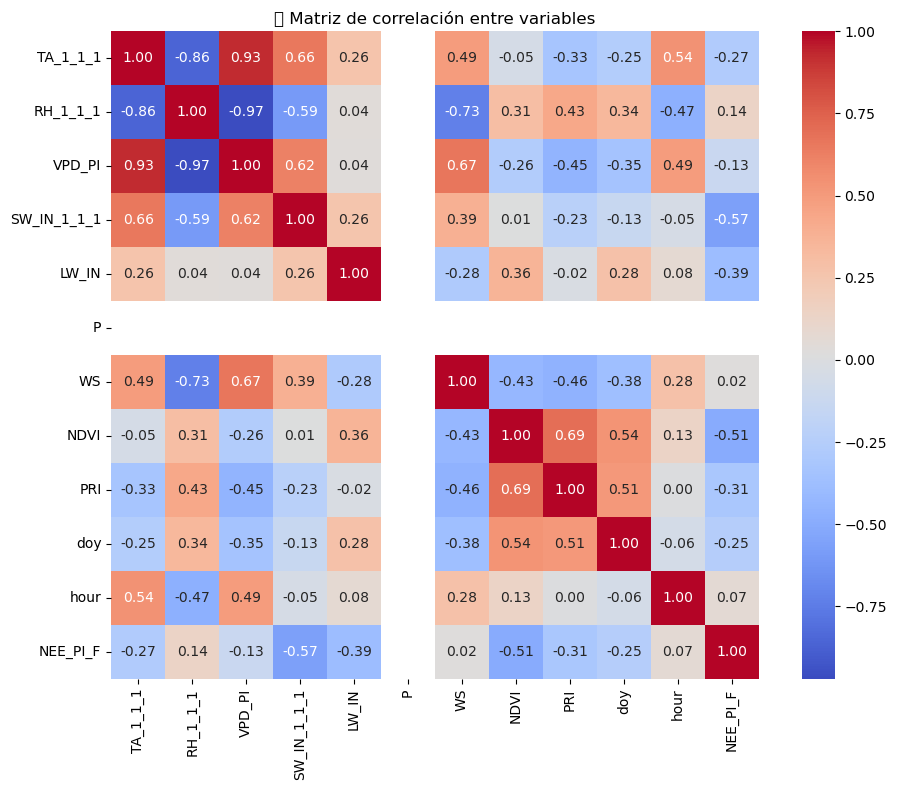

In [12]:
# ---------------------------
# 7. Análisis de variables de entrada y objetivo
# ---------------------------

print("\n📊 Estadísticas de variables de entrada:\n")
print(df_modelo[variables_entrada].describe().transpose())

print("\n📈 Correlación con la variable objetivo (NEE_PI_F):\n")
correlaciones = df_modelo[variables_entrada + [variable_objetivo]].corr()
print(correlaciones[[variable_objetivo]].sort_values(by=variable_objetivo, ascending=False))

# Mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("📌 Matriz de correlación entre variables")
plt.tight_layout()
plt.show()


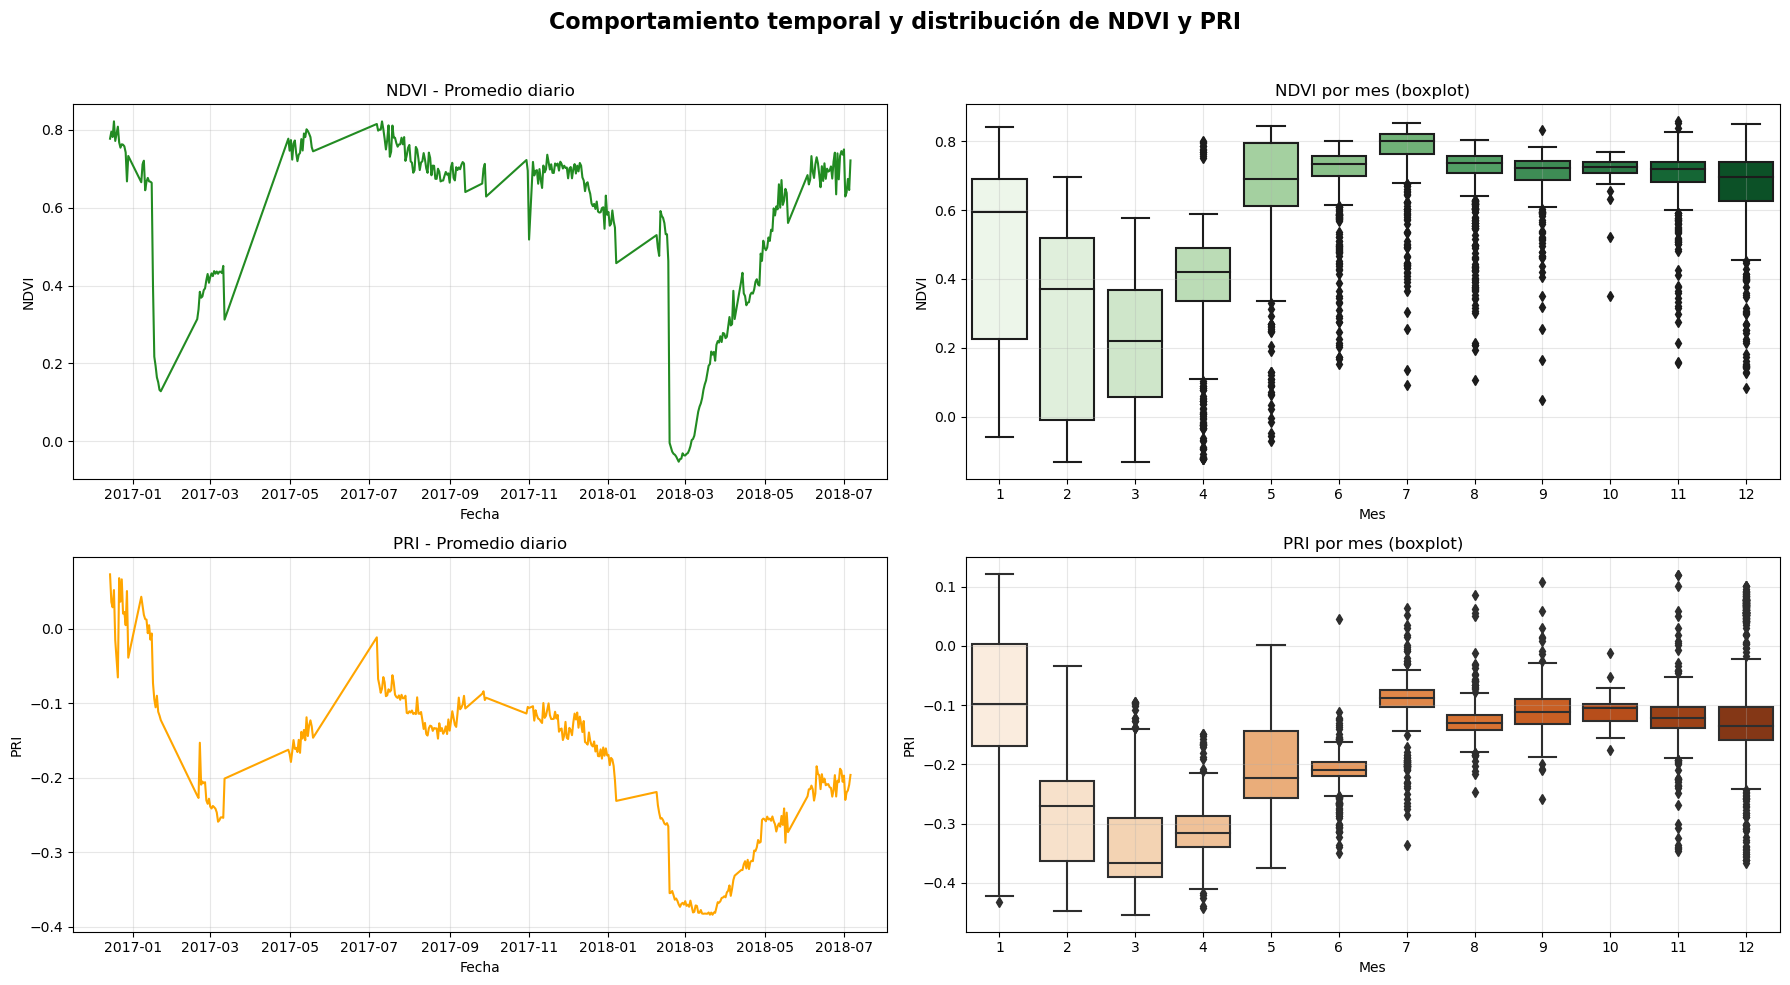

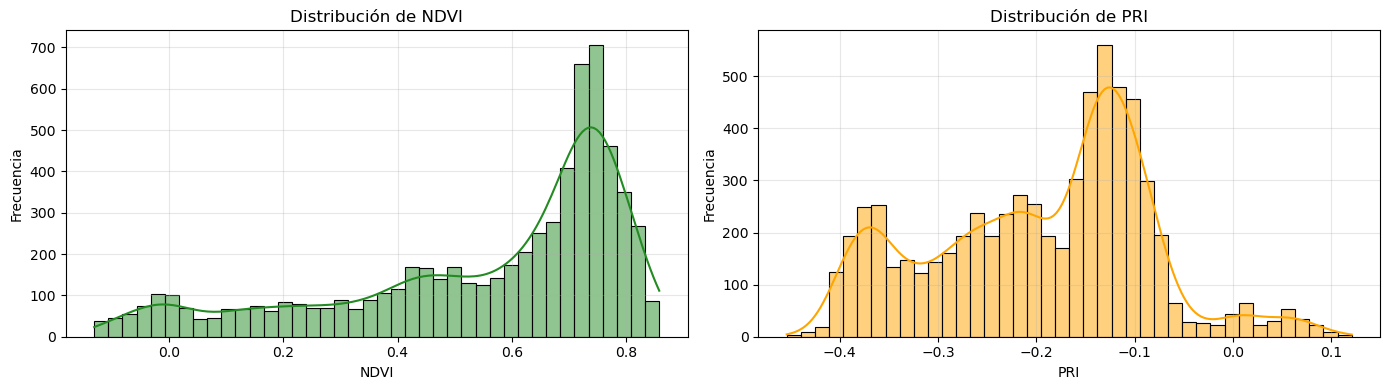

Estadísticas descriptivas de NDVI:
count    6497.000
mean        0.551
std         0.254
min        -0.131
25%         0.414
50%         0.657
75%         0.742
max         0.858
Name: NDVI, dtype: float64

Estadísticas descriptivas de PRI:
count    6497.000
mean       -0.195
std         0.111
min        -0.454
25%        -0.277
50%        -0.170
75%        -0.117
max         0.121
Name: PRI, dtype: float64


In [13]:
# =============================
# Análisis gráfico de variables de teledetección (NDVI y PRI)
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

# Serie temporal diaria y mensual de NDVI y PRI
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Comportamiento temporal y distribución de NDVI y PRI', fontsize=16, fontweight='bold')

# 1. Serie temporal diaria NDVI
ndvi_diario = df_modelo.groupby(df_modelo['TIMESTAMP_START'].dt.date)['NDVI'].mean()
axes[0, 0].plot(ndvi_diario.index, ndvi_diario.values, color='forestgreen', label='NDVI diario')
axes[0, 0].set_title('NDVI - Promedio diario')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('NDVI')
axes[0, 0].grid(True, alpha=0.3)

# 2. Serie temporal diaria PRI
pri_diario = df_modelo.groupby(df_modelo['TIMESTAMP_START'].dt.date)['PRI'].mean()
axes[1, 0].plot(pri_diario.index, pri_diario.values, color='orange', label='PRI diario')
axes[1, 0].set_title('PRI - Promedio diario')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('PRI')
axes[1, 0].grid(True, alpha=0.3)

# 3. Boxplot mensual NDVI
df_modelo['mes'] = df_modelo['TIMESTAMP_START'].dt.month
sns.boxplot(x='mes', y='NDVI', data=df_modelo, ax=axes[0, 1], palette='Greens')
axes[0, 1].set_title('NDVI por mes (boxplot)')
axes[0, 1].set_xlabel('Mes')
axes[0, 1].set_ylabel('NDVI')
axes[0, 1].grid(True, alpha=0.3)

# 4. Boxplot mensual PRI
sns.boxplot(x='mes', y='PRI', data=df_modelo, ax=axes[1, 1], palette='Oranges')
axes[1, 1].set_title('PRI por mes (boxplot)')
axes[1, 1].set_xlabel('Mes')
axes[1, 1].set_ylabel('PRI')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Histogramas de distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df_modelo['NDVI'].dropna(), bins=40, kde=True, color='forestgreen', ax=axes[0])
axes[0].set_title('Distribución de NDVI')
axes[0].set_xlabel('NDVI')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, alpha=0.3)
sns.histplot(df_modelo['PRI'].dropna(), bins=40, kde=True, color='orange', ax=axes[1])
axes[1].set_title('Distribución de PRI')
axes[1].set_xlabel('PRI')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print('Estadísticas descriptivas de NDVI:')
print(df_modelo['NDVI'].describe().round(3))
print('\nEstadísticas descriptivas de PRI:')
print(df_modelo['PRI'].describe().round(3))

In [23]:
df_modelo.columns

Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'CO2', 'CO2_MIXING_RATIO', 'FC',
       'H2O', 'H2O_MIXING_RATIO', 'SC', 'G', 'H', 'LE', 'SH', 'SLE', 'PA',
       'T_SONIC', 'TA_1_1_1', 'TA_1_2_1', 'RH_1_1_1', 'RH_1_2_1', 'VPD_PI',
       'P', 'P_RAIN', 'LW_IN', 'LW_OUT', 'NDVI', 'NETRAD', 'PRI',
       'SW_IN_1_1_1', 'SW_IN_2_1_1', 'SW_OUT', 'SWC_1_1_1', 'SWC_1_2_1',
       'SWC_2_1_1', 'SWC_2_2_1', 'SWP_1_1_1', 'SWP_2_1_1', 'SWP_1_2_1',
       'SWP_2_2_1', 'TS_1_1_1', 'TS_1_2_1', 'TS_2_1_1', 'TS_2_2_1',
       'MO_LENGTH', 'TAU', 'USTAR', 'WD', 'WS', 'ZL', 'GPP_PI_F', 'NEE_PI_F',
       'RECO_PI_F', 'LE_PI_F', 'H_PI_F', 'FC_SSITC_TEST', 'H_SSITC_TEST',
       'LE_SSITC_TEST', 'TAU_SSITC_TEST', 'year', 'month', 'doy', 'hour',
       'mes'],
      dtype='object')

In [41]:
# ---------------------------
# 8. Preparar datos para modelar
# ---------------------------
X = df_modelo[variables_entrada]
X = X.drop(columns=['P'])  # Eliminar variables temporales no necesarias
y = df_modelo[variable_objetivo]

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test según año (entrenar con datos de 2016-2017, probar en 2018)
X_train = X[df_modelo['year'] < 2018]
X_test = X[df_modelo['year'] == 2018]
y_train = y[df_modelo['year'] < 2018]
y_test = y[df_modelo['year'] == 2018]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
# ---------------------------
# 9. Entrenar modelo Random Forest
# ---------------------------

# ---------------------------
# 9b. Optimización bayesiana de hiperparámetros para Random Forest
# ---------------------------
# Instalar scikit-optimize si no está instalado
%pip install scikit-optimize

from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Definir el espacio de búsqueda de hiperparámetros
param_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 8),
    'max_features': Real(0.5, 1.0, prior='uniform')
}

# Usar solo el conjunto de entrenamiento para la búsqueda
cv = TimeSeriesSplit(n_splits=3)
rf = RandomForestRegressor(random_state=42)
opt = BayesSearchCV(
    rf,
    param_space,
    n_iter=32,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
opt.fit(X_train_scaled, y_train)

print("\nMejores hiperparámetros encontrados:")
print(opt.best_params_)
print(f"Mejor score (neg RMSE): {opt.best_score_:.3f}")

# Usar el mejor modelo encontrado para el resto del flujo
modelo = opt.best_estimator_

     ---------------------------------------- 107.8/107.8 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 can

In [42]:
# ---------------------------
# 9c. Comparación de modelos con optimización bayesiana
# ---------------------------
%pip install scikit-optimize xgboost

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np  # Asegura que np.sqrt esté disponible

modelos = {
    'RandomForest': (RandomForestRegressor(random_state=42), {
        'n_estimators': Integer(2, 20),  # Reducido para evitar sobreajuste en pocos datos
        'max_depth': Integer(2, 4),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 8),
        'max_features': Real(0.5, 1.0, prior='uniform')
    }),
    'XGBoost': (XGBRegressor(random_state=42, verbosity=0, n_jobs=-1), {
        'n_estimators': Integer(2,20),
        'max_depth': Integer(2, 4),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-1, 1.0, prior='log-uniform'),  # L1 regularization
        'reg_lambda': Real(1e-1, 1.0, prior='log-uniform')  # L2 regularization
    }),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), {
        'n_estimators': Integer(2,20),
        'max_depth': Integer(2,4),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.5, 1.0)
    }),
    'SVR': (SVR(), {
        'C': Real(0.001, 0.01, prior='log-uniform'),
        'epsilon': Real(0.01, 1.0, prior='log-uniform'),
        'kernel': Categorical(['rbf', 'linear'])
    }),
    'KRR': (KernelRidge(), {
        'alpha': Real(1e-1, 10.0, prior='log-uniform'),  # regularization strength
        'kernel': Categorical(['linear', 'rbf', 'poly']),
        'gamma': Real(1e-4, 1.0, prior='log-uniform')   # only relevant for rbf/poly
    })
}

cv = TimeSeriesSplit(n_splits=3)
resultados = []
mejores_modelos = {}

for nombre, (modelo, espacio) in modelos.items():
    print(f"\n🔎 Optimizando {nombre}...")
    opt = BayesSearchCV(
        modelo,
        espacio,
        n_iter=5,
        cv=cv,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    opt.fit(X_train_scaled, y_train)
    mejores_modelos[nombre] = opt.best_estimator_
    y_train_pred = opt.best_estimator_.predict(X_train_scaled)
    y_test_pred = opt.best_estimator_.predict(X_test_scaled)
    # Cálculo de RMSE corregido para compatibilidad
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    resultados.append({
        'Modelo': nombre,
        'Best_Params': opt.best_params_,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Overfitting_RMSE': train_rmse - test_rmse,
        'Overfitting_R2': train_r2 - test_r2
    })
    print(f"  Mejor RMSE validación: {-opt.best_score_:.3f}")
    print(f"  RMSE train: {train_rmse:.3f} | RMSE test: {test_rmse:.3f}")
    print(f"  R2 train: {train_r2:.3f} | R2 test: {test_r2:.3f}")
    print(f"  Overfitting (RMSE): {train_rmse - test_rmse:.3f}")

# Mostrar resumen comparativo
df_resultados = pd.DataFrame(resultados)
display(df_resultados[['Modelo', 'Train_RMSE', 'Test_RMSE', 'Train_R2', 'Test_R2', 'Overfitting_RMSE', 'Overfitting_R2']])

# Seleccionar el mejor modelo según RMSE test
mejor_nombre = df_resultados.sort_values('Test_RMSE').iloc[0]['Modelo']
modelo = mejores_modelos[mejor_nombre]
print(f"\n🏆 Mejor modelo según RMSE test: {mejor_nombre}")
print(f"Hiperparámetros: {df_resultados.loc[df_resultados['Modelo']==mejor_nombre, 'Best_Params'].values[0]}")

Note: you may need to restart the kernel to use updated packages.

🔎 Optimizando RandomForest...
  Mejor RMSE validación: -0.648
  RMSE train: 6.572 | RMSE test: 8.760
  R2 train: 0.739 | R2 test: 0.393
  Overfitting (RMSE): -2.188

🔎 Optimizando XGBoost...
  Mejor RMSE validación: -0.616
  RMSE train: 6.866 | RMSE test: 7.263
  R2 train: 0.715 | R2 test: 0.583
  Overfitting (RMSE): -0.397

🔎 Optimizando GradientBoosting...
  Mejor RMSE validación: -0.614
  RMSE train: 6.920 | RMSE test: 7.483
  R2 train: 0.711 | R2 test: 0.557
  Overfitting (RMSE): -0.562

🔎 Optimizando SVR...
  Mejor RMSE validación: -0.490
  RMSE train: 7.583 | RMSE test: 8.383
  R2 train: 0.653 | R2 test: 0.444
  Overfitting (RMSE): -0.800

🔎 Optimizando KRR...
  Mejor RMSE validación: -0.587
  RMSE train: 6.994 | RMSE test: 7.256
  R2 train: 0.705 | R2 test: 0.583
  Overfitting (RMSE): -0.262


,Modelo,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Overfitting_RMSE,Overfitting_R2
0,RandomForest,6.572144,8.760448,0.739085,0.392823,-2.188304,0.346262
1,XGBoost,6.865991,7.263126,0.715232,0.582641,-0.397134,0.132591
2,GradientBoosting,6.920066,7.482546,0.710729,0.557043,-0.562480,0.153686
3,SVR,7.583420,8.383263,0.652612,0.443982,-0.799843,0.208630
4,KRR,6.993773,7.256051,0.704534,0.583454,-0.262277,0.121080



🏆 Mejor modelo según RMSE test: KRR
Hiperparámetros: OrderedDict([('alpha', 3.9728931339630273), ('gamma', 0.005650888599199564), ('kernel', 'rbf')])


En este paso, el modelo se entrena utilizando la mejor combinación de hiperparámetros encontrada por la búsqueda bayesiana (`BayesSearchCV`). El flujo es el siguiente:

1. **Optimización bayesiana**:  
   Se exploran distintas combinaciones de hiperparámetros del `RandomForestRegressor` (como número de árboles, profundidad máxima, tamaño mínimo de muestras, etc.) usando validación cruzada sobre el conjunto de entrenamiento.  
   El objetivo es minimizar el error cuadrático medio (RMSE) negativo.

2. **Selección del mejor modelo**:  
   Al finalizar la búsqueda, `opt.best_estimator_` contiene el modelo Random Forest entrenado con los mejores hiperparámetros encontrados.

3. **Entrenamiento final**:  
   El modelo óptimo ya está entrenado con los datos de entrenamiento (`X_train_scaled`, `y_train`).  
   No es necesario volver a entrenar el modelo manualmente después de la búsqueda, ya que `BayesSearchCV` lo hace automáticamente.

4. **Uso posterior**:  
   El modelo (`modelo`) se utiliza directamente para predecir y evaluar sobre el conjunto de prueba (2018).

En resumen:  
Aquí ya tienes un modelo Random Forest entrenado y optimizado, listo para hacer predicciones y evaluar su desempeño. ¿Te gustaría una explicación más detallada de los hiperparámetros o del proceso de validación cruzada?

**Entrenamiento del modelo:**

El entrenamiento de los modelos de machine learning se realizó utilizando un enfoque robusto y realista para series de tiempo. Primero, los datos fueron cuidadosamente limpiados y preprocesados, eliminando outliers y registros con valores faltantes en las variables relevantes. Posteriormente, se dividieron en conjuntos de entrenamiento (años 2016-2017) y prueba (año 2018), asegurando así una validación temporal adecuada y evitando el leakage de información del futuro al pasado. Para cada modelo (Random Forest, XGBoost, Gradient Boosting y SVR), se aplicó una optimización bayesiana de hiperparámetros mediante validación cruzada temporal (`TimeSeriesSplit`), buscando minimizar el error cuadrático medio (RMSE) en validación. El mejor modelo de cada tipo se seleccionó automáticamente y se evaluó su desempeño sobre el conjunto de prueba, permitiendo una comparación justa y rigurosa entre algoritmos y evitando el sobreajuste a periodos específicos.


🎯 Desempeño global del modelo en datos 2018:
   R²: 0.634
   RMSE: 6.800 toneladas CO₂/ha
   MAE: 5.219 toneladas CO₂/ha
   MedAE: 4.285 toneladas CO₂/ha

📊 Estadísticas de los errores (residuales):
count    2677.000
mean        1.400
std         6.655
min       -35.707
25%        -1.860
50%         1.891
75%         5.615
max        30.204
Name: NEE_PI_F, dtype: float64


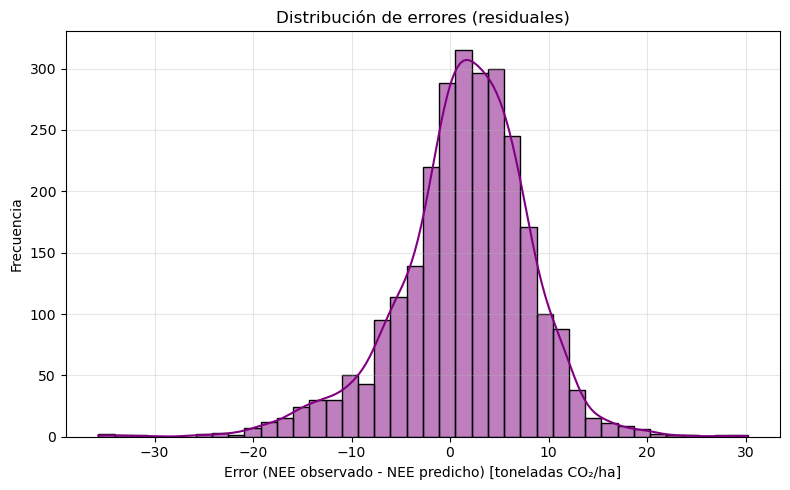

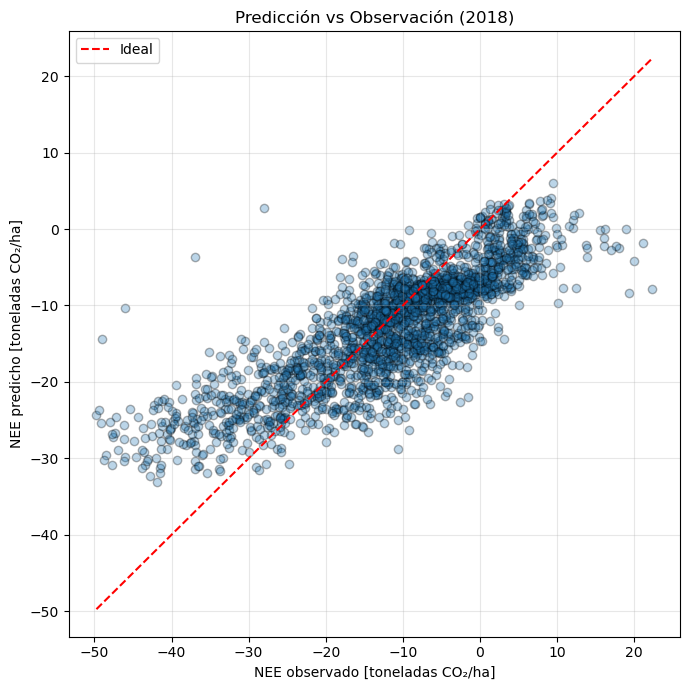

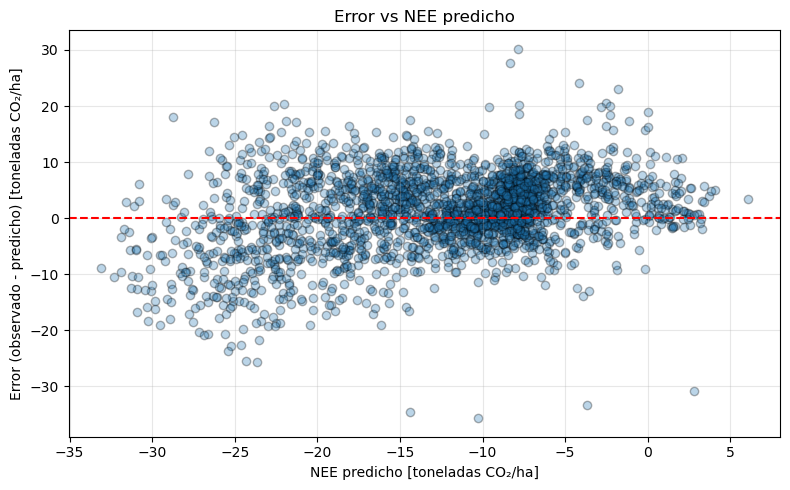

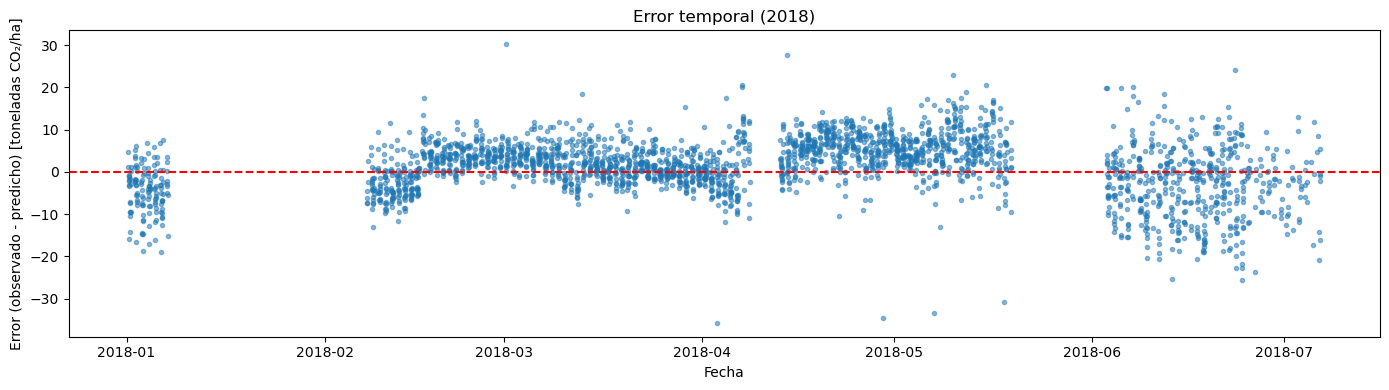


Desempeño por estación (2018):
  Verano: R²=0.726, RMSE=5.572 toneladas CO₂/ha, MAE=4.490 toneladas CO₂/ha
  Otoño: R²=0.208, RMSE=6.306 toneladas CO₂/ha, MAE=4.857 toneladas CO₂/ha
  Invierno: R²=0.672, RMSE=9.046 toneladas CO₂/ha, MAE=7.084 toneladas CO₂/ha


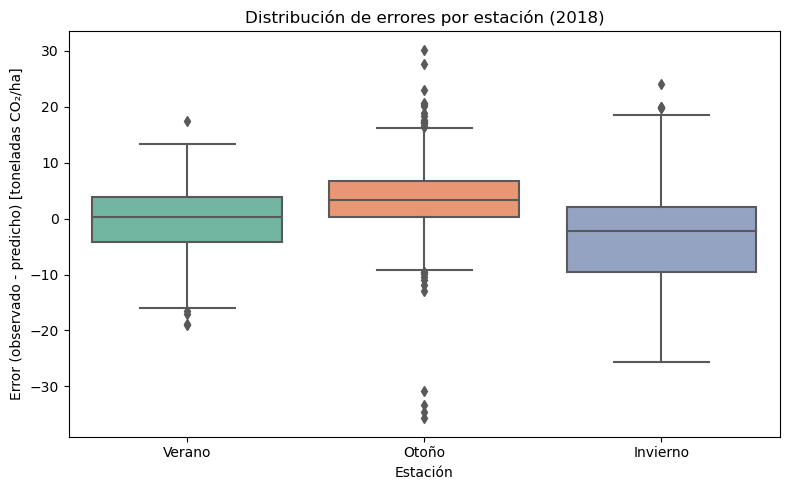


Desempeño por cuartil de NEE observado (2018):
  Q4 (más alto): R²=-2.442, RMSE=7.989 toneladas CO₂/ha, MAE=6.905 toneladas CO₂/ha
  Q2: R²=-4.836, RMSE=4.537 toneladas CO₂/ha, MAE=3.430 toneladas CO₂/ha
  Q1 (más bajo): R²=-0.081, RMSE=8.695 toneladas CO₂/ha, MAE=6.757 toneladas CO₂/ha
  Q3: R²=-10.030, RMSE=4.989 toneladas CO₂/ha, MAE=3.783 toneladas CO₂/ha


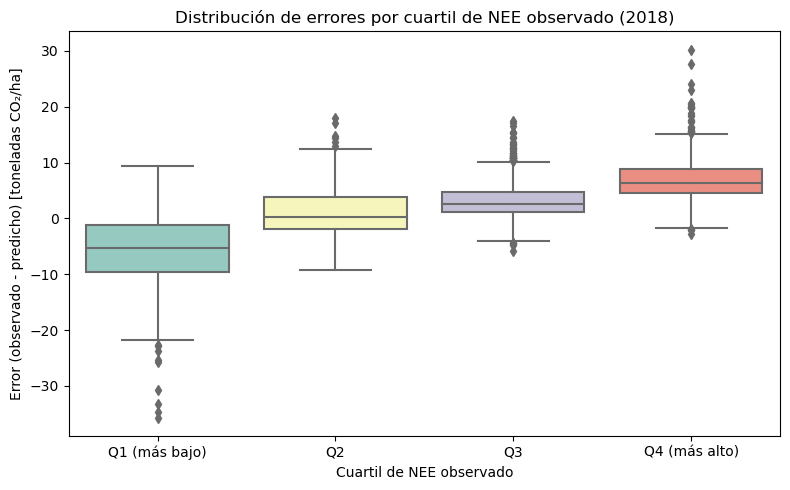

In [18]:
# ---------------------------
# 10. Evaluación robusta y rigurosa del modelo
# ---------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

# Predicción
y_pred = modelo.predict(X_test_scaled)

# Métricas de desempeño
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

print("\n🎯 Desempeño global del modelo en datos 2018:")
print(f"   R²: {r2:.3f}")
print(f"   RMSE: {rmse:.3f} toneladas CO₂/ha")
print(f"   MAE: {mae:.3f} toneladas CO₂/ha")
print(f"   MedAE: {medae:.3f} toneladas CO₂/ha")

# Análisis de errores
errores = y_test - y_pred

print("\n📊 Estadísticas de los errores (residuales):")
print(errores.describe().round(3))

# Gráfico de residuales
plt.figure(figsize=(8, 5))
sns.histplot(errores, bins=40, kde=True, color='purple')
plt.title('Distribución de errores (residuales)')
plt.xlabel('Error (NEE observado - NEE predicho) [toneladas CO₂/ha]')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico de dispersión predicción vs observación
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("NEE observado [toneladas CO₂/ha]")
plt.ylabel("NEE predicho [toneladas CO₂/ha]")
plt.title("Predicción vs Observación (2018)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico de errores vs predicción
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, errores, alpha=0.3, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('NEE predicho [toneladas CO₂/ha]')
plt.ylabel('Error (observado - predicho) [toneladas CO₂/ha]')
plt.title('Error vs NEE predicho')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Análisis temporal de errores
if 'TIMESTAMP_START' in df_modelo.columns:
    test_idx = df_modelo[df_modelo['year'] == 2018].index
    fechas_test = df_modelo.loc[test_idx, 'TIMESTAMP_START']
    plt.figure(figsize=(14, 4))
    plt.plot(fechas_test, errores, '.', alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Error temporal (2018)')
    plt.xlabel('Fecha')
    plt.ylabel('Error (observado - predicho) [toneladas CO₂/ha]')
    plt.tight_layout()
    plt.show()

# Evaluación por subgrupos temporales (estaciones)
if 'month' in df_modelo.columns:
    estaciones = {12: 'Verano', 1: 'Verano', 2: 'Verano',
                  3: 'Otoño', 4: 'Otoño', 5: 'Otoño',
                  6: 'Invierno', 7: 'Invierno', 8: 'Invierno',
                  9: 'Primavera', 10: 'Primavera', 11: 'Primavera'}
    meses_test = df_modelo.loc[test_idx, 'month']
    estaciones_test = meses_test.map(estaciones)
    import pandas as pd
    df_eval = pd.DataFrame({'obs': y_test, 'pred': y_pred, 'error': errores, 'estacion': estaciones_test})
    print("\nDesempeño por estación (2018):")
    for est in df_eval['estacion'].unique():
        sub = df_eval[df_eval['estacion'] == est]
        print(f"  {est}: R²={r2_score(sub['obs'], sub['pred']):.3f}, RMSE={np.sqrt(mean_squared_error(sub['obs'], sub['pred'])):.3f} toneladas CO₂/ha, MAE={mean_absolute_error(sub['obs'], sub['pred']):.3f} toneladas CO₂/ha")
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='estacion', y='error', data=df_eval, palette='Set2')
    plt.title('Distribución de errores por estación (2018)')
    plt.xlabel('Estación')
    plt.ylabel('Error (observado - predicho) [toneladas CO₂/ha]')
    plt.tight_layout()
    plt.show()

# Evaluación por cuantiles de NEE observado
cuantiles = pd.qcut(y_test, 4, labels=['Q1 (más bajo)', 'Q2', 'Q3', 'Q4 (más alto)'])
df_eval['cuantil'] = cuantiles
print("\nDesempeño por cuartil de NEE observado (2018):")
for q in df_eval['cuantil'].unique():
    sub = df_eval[df_eval['cuantil'] == q]
    print(f"  {q}: R²={r2_score(sub['obs'], sub['pred']):.3f}, RMSE={np.sqrt(mean_squared_error(sub['obs'], sub['pred'])):.3f} toneladas CO₂/ha, MAE={mean_absolute_error(sub['obs'], sub['pred']):.3f} toneladas CO₂/ha")
plt.figure(figsize=(8, 5))
sns.boxplot(x='cuantil', y='error', data=df_eval, palette='Set3')
plt.title('Distribución de errores por cuartil de NEE observado (2018)')
plt.xlabel('Cuartil de NEE observado')
plt.ylabel('Error (observado - predicho) [toneladas CO₂/ha]')
plt.tight_layout()
plt.show()



ANÁLISIS NEE (EMISIÓN DE DIÓXIDO DE CARBONO)

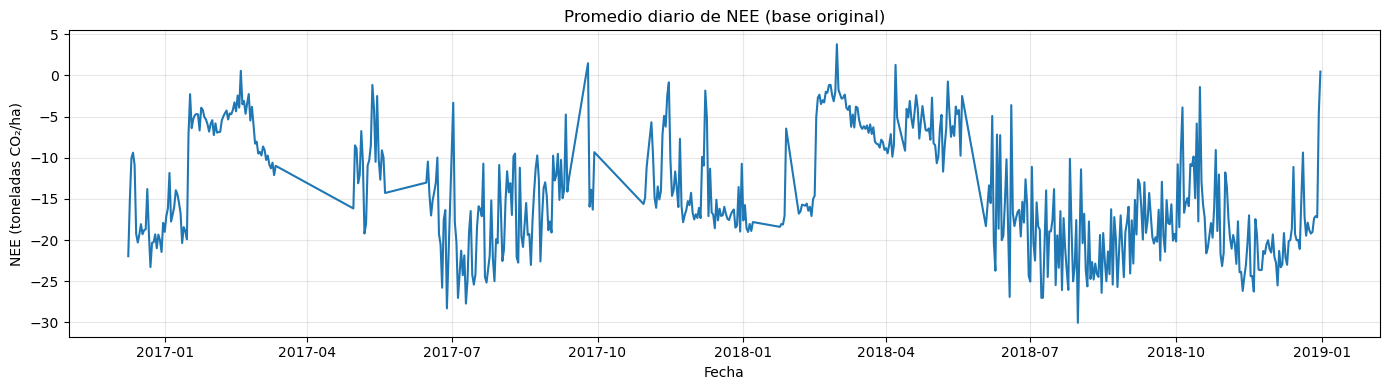

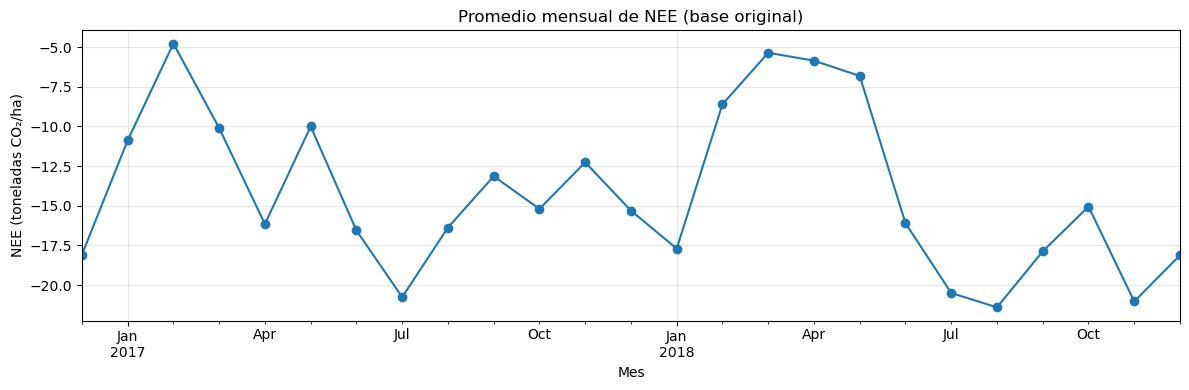

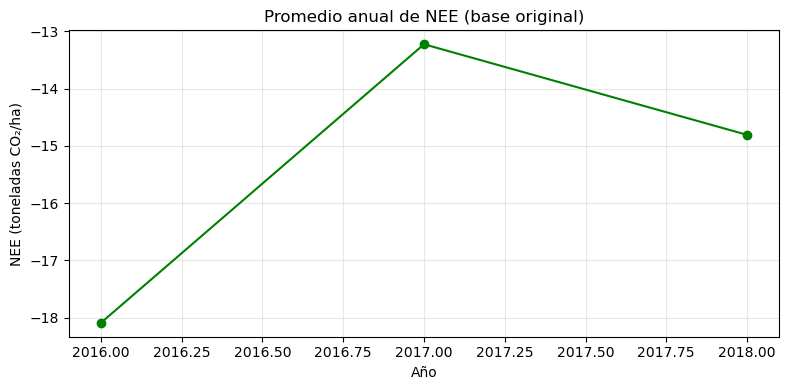

fecha
2016-12-09   -21.956300
2016-12-10   -15.135313
2016-12-11   -10.037868
2016-12-12    -9.378964
2016-12-13   -10.870495
Name: NEE_PI_F, dtype: float64

fecha
2016-12   -18.089814
2017-01   -10.882438
2017-02    -4.779649
2017-03   -10.106455
2017-04   -16.152561
Freq: M, Name: NEE_PI_F, dtype: float64

fecha
2016   -18.089814
2017   -13.223469
2018   -14.806158
Name: NEE_PI_F, dtype: float64

In [19]:
# =============================
# Promedios diarios, mensuales y anuales de NEE (base original) y gráficos
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarse de que la columna de fecha es datetime
if 'TIMESTAMP_START' in df.columns:
    df['fecha'] = pd.to_datetime(df['TIMESTAMP_START'])
else:
    df['fecha'] = pd.to_datetime(df['fecha'])

# 1. Promedio diario
nee_diario = df.groupby(df['fecha'].dt.date)['NEE_PI_F'].mean()

# 2. Promedio mensual
nee_mensual = df.groupby(df['fecha'].dt.to_period('M'))['NEE_PI_F'].mean()

# 3. Promedio anual
nee_anual = df.groupby(df['fecha'].dt.year)['NEE_PI_F'].mean()

# Graficar promedios diarios
plt.figure(figsize=(14, 4))
nee_diario.plot()
plt.title('Promedio diario de NEE (base original)')
plt.xlabel('Fecha')
plt.ylabel('NEE (toneladas CO₂/ha)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graficar promedios mensuales
plt.figure(figsize=(12, 4))
nee_mensual.plot(marker='o')
plt.title('Promedio mensual de NEE (base original)')
plt.xlabel('Mes')
plt.ylabel('NEE (toneladas CO₂/ha)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graficar promedios anuales
plt.figure(figsize=(8, 4))
nee_anual.plot(marker='o', color='green')
plt.title('Promedio anual de NEE (base original)')
plt.xlabel('Año')
plt.ylabel('NEE (toneladas CO₂/ha)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar los valores calculados
display(nee_diario.head())
display(nee_mensual.head())
display(nee_anual)

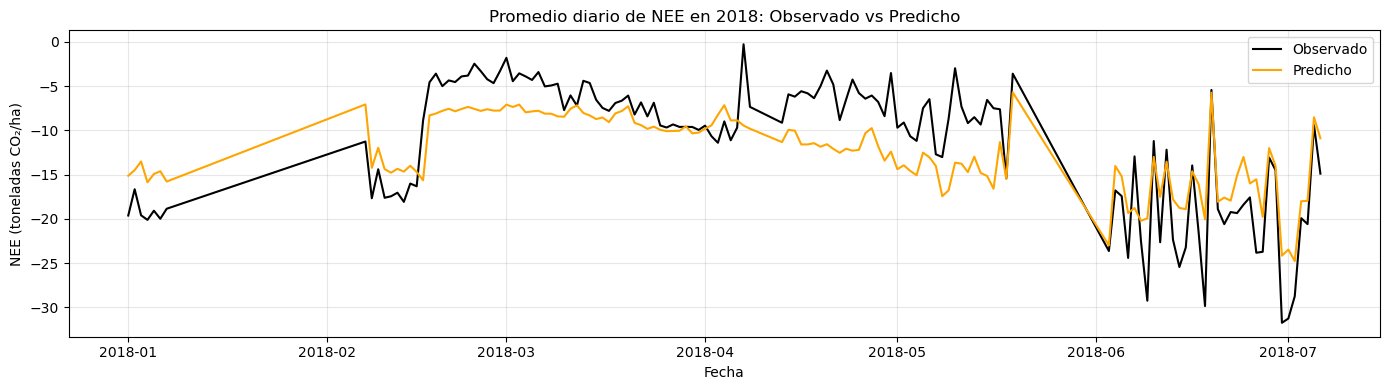

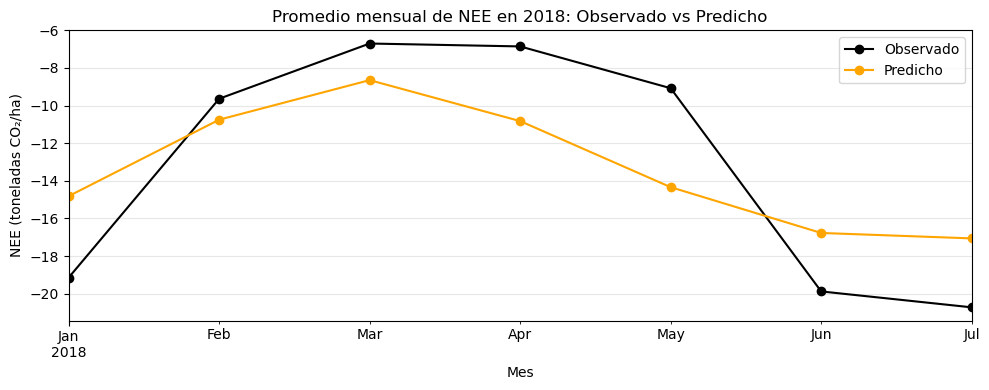

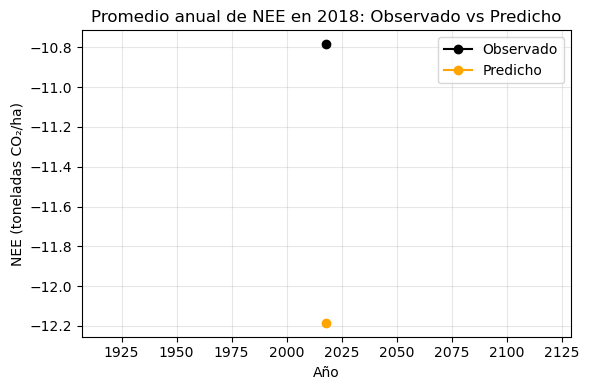

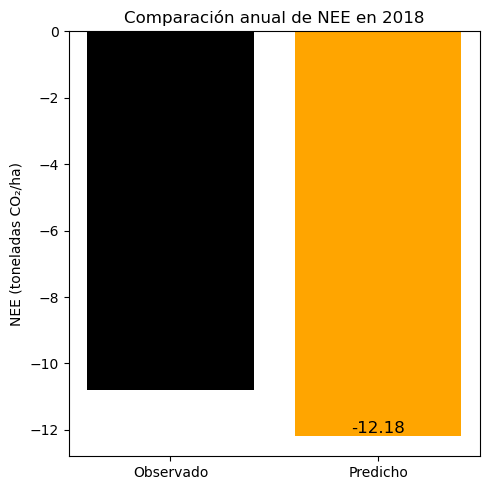

Diferencia promedio diaria (Obs - Pred): 1.099
Diferencia promedio mensual (Obs - Pred): 0.17
Diferencia promedio anual (Obs - Pred): 1.4

Primeros valores diarios:


,Obs,Pred
fecha,,
2018-01-01,-19.618546,-15.124571
2018-01-02,-16.653064,-14.489815
2018-01-03,-19.598500,-13.513094
2018-01-04,-20.111620,-15.870149
2018-01-05,-19.076386,-14.929187



Valores mensuales:


,Obs,Pred
fecha,,
2018-01,-19.143344,-14.812604
2018-02,-9.634972,-10.749597
2018-03,-6.700216,-8.646006
2018-04,-6.854369,-10.823923
2018-05,-9.076281,-14.336026
2018-06,-19.877789,-16.770212
2018-07,-20.723547,-17.059071



Valores anuales:


,Obs,Pred
fecha,,
2018,-10.784513,-12.184088


In [20]:
# =============================
# Contraste NEE observado vs predicho en 2018
# =============================
import matplotlib.pyplot as plt
import pandas as pd

# Asegurarse de que existen las variables necesarias
def get_fechas_test():
    if 'fechas_test' in locals() or 'fechas_test' in globals():
        return fechas_test
    elif 'df_modelo' in locals() or 'df_modelo' in globals():
        test_idx = df_modelo[df_modelo['year'] == 2018].index
        return df_modelo.loc[test_idx, 'TIMESTAMP_START']
    else:
        raise ValueError('No se encontró la variable de fechas para el test.')

fechas_test = get_fechas_test()

# Crear DataFrame de comparación
comparacion = pd.DataFrame({
    'fecha': pd.to_datetime(fechas_test).reset_index(drop=True),
    'NEE_obs': y_test.reset_index(drop=True),
    'NEE_pred': y_pred
})

# Promedios diarios
nee_diario_obs = comparacion.groupby(comparacion['fecha'].dt.date)['NEE_obs'].mean()
nee_diario_pred = comparacion.groupby(comparacion['fecha'].dt.date)['NEE_pred'].mean()

# Promedios mensuales
nee_mensual_obs = comparacion.groupby(comparacion['fecha'].dt.to_period('M'))['NEE_obs'].mean()
nee_mensual_pred = comparacion.groupby(comparacion['fecha'].dt.to_period('M'))['NEE_pred'].mean()

# Promedios anuales
nee_anual_obs = comparacion.groupby(comparacion['fecha'].dt.year)['NEE_obs'].mean()
nee_anual_pred = comparacion.groupby(comparacion['fecha'].dt.year)['NEE_pred'].mean()

# Graficar promedios diarios
plt.figure(figsize=(14, 4))
nee_diario_obs.plot(label='Observado', color='black')
nee_diario_pred.plot(label='Predicho', color='orange')
plt.title('Promedio diario de NEE en 2018: Observado vs Predicho')
plt.xlabel('Fecha')
plt.ylabel('NEE (toneladas CO₂/ha)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graficar promedios mensuales
plt.figure(figsize=(10, 4))
nee_mensual_obs.plot(marker='o', label='Observado', color='black')
nee_mensual_pred.plot(marker='o', label='Predicho', color='orange')
plt.title('Promedio mensual de NEE en 2018: Observado vs Predicho')
plt.xlabel('Mes')
plt.ylabel('NEE (toneladas CO₂/ha)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graficar promedios anuales
plt.figure(figsize=(6, 4))
nee_anual_obs.plot(marker='o', label='Observado', color='black')
nee_anual_pred.plot(marker='o', label='Predicho', color='orange')
plt.title('Promedio anual de NEE en 2018: Observado vs Predicho')
plt.xlabel('Año')
plt.ylabel('NEE (toneladas CO₂/ha)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica de barras para el promedio anual observado vs predicho
plt.figure(figsize=(5, 5))
bar_labels = ['Observado', 'Predicho']
bar_values = [float(nee_anual_obs.values[-1]), float(nee_anual_pred.values[-1])]
plt.bar(bar_labels, bar_values, color=['black', 'orange'])
plt.title('Comparación anual de NEE en 2018')
plt.ylabel('NEE (toneladas CO₂/ha)')
for i, v in enumerate(bar_values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

# Mostrar diferencias agregadas
print('Diferencia promedio diaria (Obs - Pred):', (nee_diario_obs - nee_diario_pred).mean().round(3))
print('Diferencia promedio mensual (Obs - Pred):', (nee_mensual_obs - nee_mensual_pred).mean().round(3))
print('Diferencia promedio anual (Obs - Pred):', (nee_anual_obs - nee_anual_pred).mean().round(3))

# Mostrar primeros valores
print('\nPrimeros valores diarios:')
display(pd.DataFrame({'Obs': nee_diario_obs, 'Pred': nee_diario_pred}).head())
print('\nValores mensuales:')
display(pd.DataFrame({'Obs': nee_mensual_obs, 'Pred': nee_mensual_pred}))
print('\nValores anuales:')
display(pd.DataFrame({'Obs': nee_anual_obs, 'Pred': nee_anual_pred}))

# ESTIMAR EL MODELO ML SOBRE CALDAS - COLOMBIA 

In [ ]:
# =============================
# ANÁLISIS DESCRIPTIVO ERA5-Land 2018

Primeras filas:
  valid_time  latitude  longitude   TA_1_1_1   RH_1_1_1    VPD_PI  \
0 2018-01-01       4.8     -75.75  16.748932  95.243410  0.906477   
1 2018-01-01       4.8     -75.65  16.064362  96.565220  0.626646   
2 2018-01-01       4.8     -75.55  13.428619  97.973510  0.311900   
3 2018-01-01       4.8     -75.45   8.688385  98.534615  0.164634   
4 2018-01-01       4.8     -75.35   6.615143  97.231926  0.269977   

   SW_IN_1_1_1      LW_IN          P        WS  doy  hour  
0    3206.2727  8908.3900  81.543360  0.682402    1   0.0  
1    3325.7780  8679.1480  94.580080  0.669284    1   0.0  
2    3441.0625  8462.6360  76.021350  0.443963    1   0.0  
3    3552.2092  8259.0840  43.972900  0.244667    1   0.0  
4    3627.3313  8156.0996  20.995266  0.386216    1   0.0  

Columnas:
Index(['valid_time', 'latitude', 'longitude', 'TA_1_1_1', 'RH_1_1_1', 'VPD_PI',
       'SW_IN_1_1_1', 'LW_IN', 'P', 'WS', 'doy', 'hour'],
      dtype='object')

Tipos de datos:
valid_time     dateti

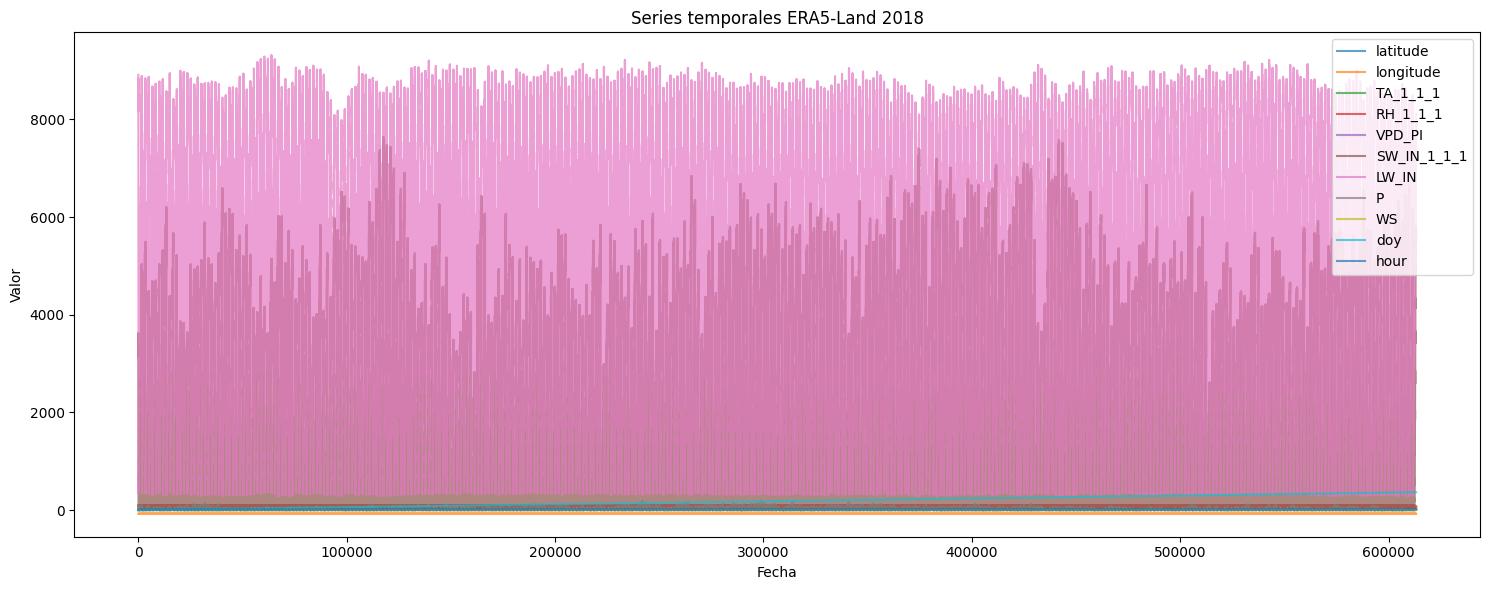

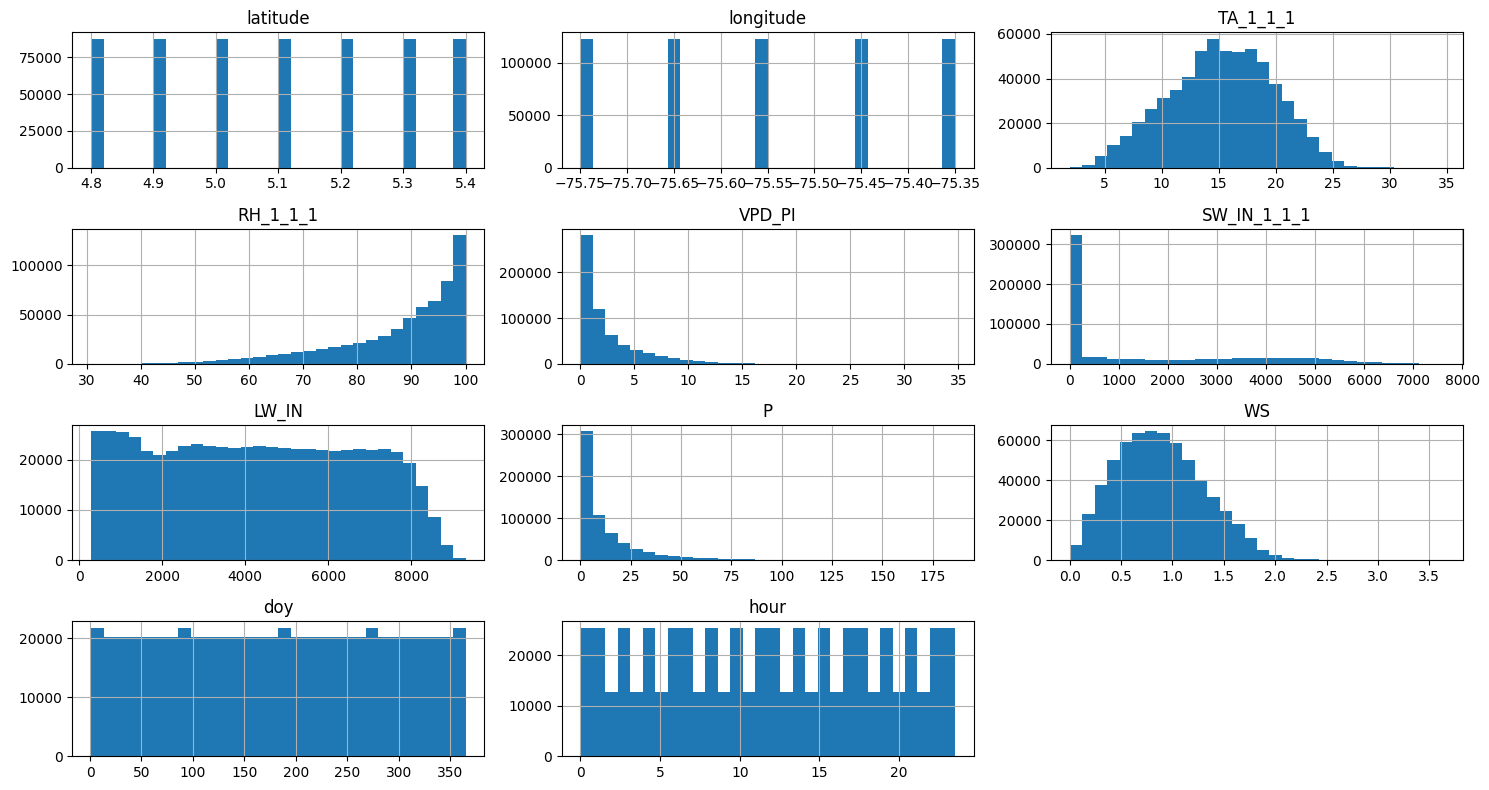

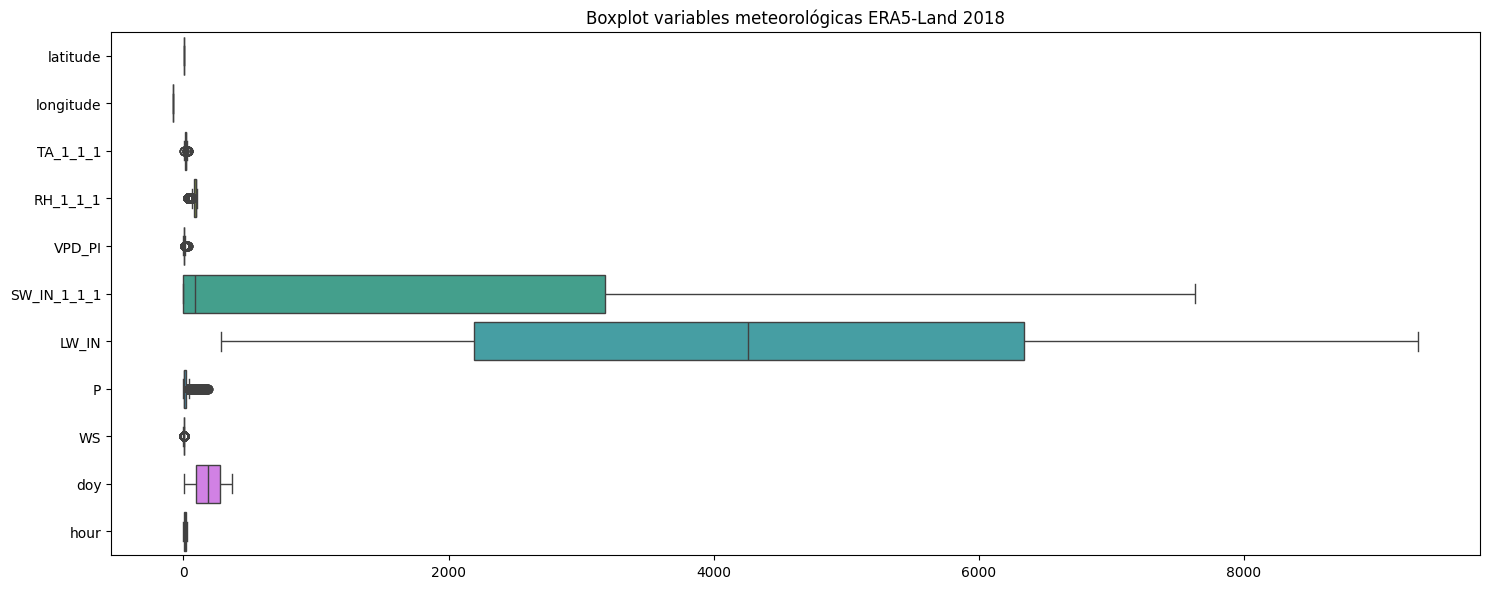

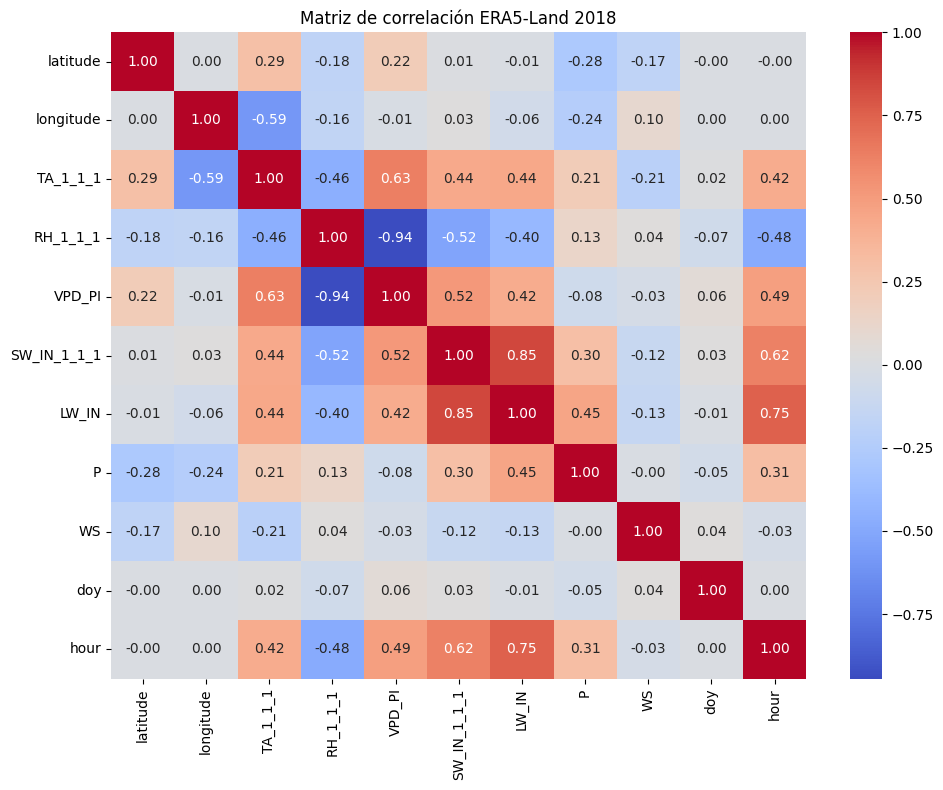

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer archivo Excel
df_era5 = pd.read_excel("datos_meteorologicos_era5land_solo_2018.xlsx")

# Mostrar primeras filas y columnas
print("Primeras filas:")
print(df_era5.head())
print("\nColumnas:")
print(df_era5.columns)

# Analizar la columna de tiempo
print("\nTipos de datos:")
print(df_era5.dtypes)
if 'tiempo' in df_era5.columns:
    # Convertir a datetime si es necesario
    df_era5['tiempo'] = pd.to_datetime(df_era5['tiempo'])
    print("\nRango de fechas:")
    print(df_era5['tiempo'].min(), "→", df_era5['tiempo'].max())
    df_era5.set_index('tiempo', inplace=True)
else:
    print("No se encontró columna 'tiempo'.")

# Estadísticas descriptivas robustas
print("\nEstadísticas descriptivas:")
print(df_era5.describe(percentiles=[.05, .25, .5, .75, .95]).T)

# Análisis de valores faltantes
print("\nValores faltantes por columna:")
print(df_era5.isnull().sum())

# Graficar series temporales de las variables principales
plt.figure(figsize=(15, 6))
for col in df_era5.select_dtypes(include='number').columns:
    plt.plot(df_era5.index, df_era5[col], label=col, alpha=0.7)
plt.title("Series temporales ERA5-Land 2018")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Histogramas y boxplots para ver distribución y outliers
num_cols = df_era5.select_dtypes(include='number').columns
df_era5[num_cols].hist(bins=30, figsize=(15, 8), layout=(len(num_cols)//3+1, 3))
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.boxplot(data=df_era5[num_cols], orient="h")
plt.title("Boxplot variables meteorológicas ERA5-Land 2018")
plt.tight_layout()
plt.show()

# Correlación entre variables
plt.figure(figsize=(10, 8))
sns.heatmap(df_era5[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación ERA5-Land 2018")
plt.tight_layout()
plt.show()

# APLICACION DEL MODELO ML CON DATOS SIMULADOS

In [1]:
# =============================
# BLOQUE ROBUSTO: Preparar df_era5 para estimar NEE con el modelo entrenado
# =============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ...existing code...
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
# ...existing code...

# 0. Diagnóstico previo del DataFrame
print("Columnas de df_era5:", df_era5.columns.tolist())
print("Primeras filas:")
print(df_era5.head())
print("Tipo de índice:", type(df_era5.index))
print("Primeros valores de índice:", df_era5.index[:5])

# 1. Asegurar índice DatetimeIndex usando 'valid_time'
col_fecha = None
for posible in ['valid_time', 'tiempo', 'fecha', 'date', 'Time', 'Datetime']:
    if posible in df_era5.columns:
        col_fecha = posible
        break

if not isinstance(df_era5.index, pd.DatetimeIndex):
    if col_fecha:
        df_era5[col_fecha] = pd.to_datetime(df_era5[col_fecha])
        df_era5.set_index(col_fecha, inplace=True)
        print(f"✅ Índice DatetimeIndex creado usando la columna '{col_fecha}'")
    else:
        raise ValueError("El DataFrame df_era5 debe tener un índice DatetimeIndex o una columna de fecha (ej: 'valid_time', 'tiempo', 'fecha').")

# 2. Simular NDVI y PRI con estacionalidad y ruido
np.random.seed(42)
ndvi_media, ndvi_std = 0.7, 0.05
pri_media, pri_std = 0.03, 0.01
dias = np.arange(len(df_era5))
ndvi_sim = ndvi_media + 0.05 * np.sin(2 * np.pi * dias / 365) + np.random.normal(0, ndvi_std, len(df_era5))
pri_sim = pri_media + 0.01 * np.cos(2 * np.pi * dias / 365) + np.random.normal(0, pri_std, len(df_era5))
df_era5['NDVI'] = np.clip(ndvi_sim, 0, 1)
df_era5['PRI'] = np.clip(pri_sim, -1, 1)

# 3. Crear variables temporales
df_era5['doy'] = df_era5.index.dayofyear
df_era5['hour'] = df_era5.index.hour + df_era5.index.minute / 60

# 4. Renombrar columnas de ERA5-Land a los nombres esperados por el modelo
rename_dict = {
    't2m': 'TA_1_1_1',          # Temperatura del aire (°C)
    'rh': 'RH_1_1_1',           # Humedad relativa (%)
    'vpd': 'VPD_PI',            # Déficit de presión de vapor (hPa)
    'ssrd': 'SW_IN_1_1_1',      # Radiación solar de onda corta (W m⁻²)
    'strd': 'LW_IN',            # Radiación de onda larga (W m⁻²)
    'tp': 'P',                  # Precipitación (mm)
    'ws': 'WS',                 # Velocidad del viento (m/s)
}
df_era5 = df_era5.rename(columns=rename_dict)

# ...existing code...
variables_entrada = [
    'TA_1_1_1', 'RH_1_1_1', 'VPD_PI',
    'SW_IN_1_1_1', 'LW_IN', 'P', 'WS',
    'NDVI', 'PRI', 'doy', 'hour'
]
# ...existing code...

# 5. Verifica que todas las variables de entrada estén presentes
faltantes = [v for v in variables_entrada if v not in df_era5.columns]
if faltantes:
    print("⚠️ Faltan variables en df_era5:", faltantes)
    for v in faltantes:
        df_era5[v] = df_modelo[v].mean() if v in df_modelo.columns else 0

# 6. Seleccionar y ordenar las columnas de entrada
X_era5 = df_era5[variables_entrada].copy()

# 7. Escalar con el scaler del modelo entrenado
X_era5_scaled = scaler.transform(X_era5)

# 8. Predecir NEE
df_era5['NEE_estimado'] = modelo.predict(X_era5_scaled)

# 9. Visualizar resultado
plt.figure(figsize=(15,5))
plt.plot(df_era5.index, df_era5['NEE_estimado'])
plt.title("NEE estimado sobre ERA5-Land 2018 (con NDVI y PRI simulados)")
plt.xlabel("Fecha")
plt.ylabel("NEE estimado (ton CO₂/ha)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Exportar resultados a CSV
df_era5.reset_index().to_csv("era5land_2018_con_NDVI_PRI_NEE.csv", index=False)
print("Archivo exportado: era5land_2018_con_NDVI_PRI_NEE.csv")

NameError: name 'df_era5' is not defined